<h1>Portfolio Optimization with Regulization</h1>

<p style='text-align: justify'>This project aims to optimize a portfolio using the minimum variance portfolio, while incorporating regularization techniques. The regularization method used is L1 (Lasso) regression, which promotes sparsity by adding a penalty term to the loss function. The code is based on the paper <a href='https://www.ecb.europa.eu/pub/pdf/scpwps/ecbwp936.pdf'>Sparse and stable Markowitz portfolios</a> published by Joshua Bordie, Ingrid Daubechies, Christine De Mol, Domenico Giannone and Ignace Loris.</p>

<h3>Import required packages</h3>

In [1]:
# Data source and manipulation
import pandas_datareader
import pandas as pd
import yfinance as yf

# Checking for stationarity
from statsmodels.tsa.stattools import adfuller

# Mathematical operations and optimizations
from scipy.optimize import minimize, OptimizeResult, differential_evolution # since cvxpy can only solve convex problems, we use functions from scipy.optimize to solve for the sharpe ratio
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Working with dates
from datetime import datetime

# OLS model for linear regression
import statsmodels.api as sm

# Ignore warnings
from warnings import filterwarnings
filterwarnings('ignore')

<h3>Receiving Data</h3>
The projects utilizes historic returns from portfolios provided by the Fama/French database. The pandas data reader is used to make the necessary API calls to receive data from the online database.

In [2]:
def get_available_fama_french_datasets() -> list[str]:
    """
    This function retrieves a list of available datasets from the Fama/French database.
    
    Parameters:
    None
    
    Returns:
    list[str]: A list of strings representing the available datasets.
    """
    return pandas_datareader.famafrench.get_available_datasets()

def get_fama_french_data(dataset_name: str, start: str = None, end: str = None, print_description: bool = False) -> pd.DataFrame:
    """
    This function retrieves and processes data from the Fama/French database. For further information check the documentation at:
    https://pandas-datareader.readthedocs.io/en/latest/readers/famafrench.html. 
    
    Parameters:
    dataset_name (str): The name of the dataset to retrieve.
    start (str, optional): The start date for the data retrieval.
    end (str, optional): The end date for the data retrieval. If not provided, data will end at the latest available date.
    print_description (bool, optional): If True, the function will print the description of the dataset. Default is False.
    
    Returns:
    pd.DataFrame: A pandas DataFrame containing the retrieved data. If an error occurs during retrieval or processing, the function returns None.
    """
    # Try to download the specified dataset from the fama french database
    try:
        data: dict = pandas_datareader.famafrench.FamaFrenchReader(dataset_name, start=start, end=end).read()
    except Exception as e:
        print(f"Error fetching data for dataset '{dataset_name}': {str(e)}")
        return None
    
    # Print dataset description if requested
    try:
        if print_description:
            print(data['DESCR'])
    except KeyError as e:
        print(f"No dataset description found for dataset '{dataset_name}'")
    
    # Return the DataFrame from the loaded dataset
    try:
        return data[0]
    except KeyError as e:
        print(f"No DataFrame found for dataset '{dataset_name}'")
        return None
    
def convert_percentage_to_decimal(dataset: pd.DataFrame) -> pd.DataFrame:
    """
    This function converts the percentage values in a pandas DataFrame to decimal form.
    
    Parameters:
    dataset (pd.DataFrame): The DataFrame containing the percentage values. The DataFrame should have column names.
    
    Returns:
    pd.DataFrame: The DataFrame with the percentage values converted to decimal form. If a TypeError occurs during the conversion,
    the function prints an error message and returns the original DataFrame.
    """
    for col in dataset.columns:
        try:
            dataset[col] = dataset[col] / 100
        except TypeError as e:
            print(f"Unable to convert column '{col}' to decimal: {e}")
    return dataset

<h3>Download the data for a portfolio consisting of sub portfolios representing 48 industries</h3>

In [3]:
start: str = '2000-01-01'
end: str = '2025-01-01'
data: pd.DataFrame = get_fama_french_data(dataset_name='10_Industry_Portfolios_daily', start=start, end=end) # 5, 10, 48 Industry Portfolios available
data: pd.DataFrame = convert_percentage_to_decimal(data)
data.head()

NoDur   Durbl   Manuf   Enrgy   HiTec   Telcm   Shops   Hlth   \
Date                                                                         
2000-01-03 -0.0165 -0.0135 -0.0247 -0.0313  0.0244 -0.0121 -0.0230 -0.0058   
2000-01-04 -0.0181 -0.0263 -0.0267 -0.0195 -0.0534 -0.0428 -0.0330 -0.0439   
2000-01-05 -0.0013 -0.0007  0.0056  0.0226 -0.0110  0.0026 -0.0040  0.0231   
2000-01-06  0.0068  0.0062  0.0216  0.0399 -0.0492 -0.0198  0.0020  0.0268   
2000-01-07  0.0211  0.0471  0.0320  0.0118  0.0350  0.0096  0.0427  0.0760   

             Utils   Other  
Date                        
2000-01-03 -0.0236 -0.0332  
2000-01-04  0.0049 -0.0368  
2000-01-05  0.0349 -0.0038  
2000-01-06  0.0067  0.0235  
2000-01-07  0.0119  0.0199

<h3>First descriptive statistics of the dataset</h3>

In [4]:
data.describe()

NoDur        Durbl        Manuf        Enrgy        HiTec  \
count  6289.000000  6289.000000  6289.000000  6289.000000  6289.000000   
mean      0.000387     0.000547     0.000420     0.000468     0.000440   
std       0.009567     0.019698     0.012814     0.017984     0.016672   
min      -0.098700    -0.144900    -0.110300    -0.196800    -0.131400   
25%      -0.004100    -0.008500    -0.005700    -0.008200    -0.006800   
50%       0.000600     0.000800     0.000800     0.000600     0.001100   
75%       0.005300     0.009700     0.006800     0.009800     0.008000   
max       0.102400     0.149800     0.107400     0.191600     0.160000   

             Telcm        Shops        Hlth         Utils        Other  
count  6289.000000  6289.000000  6289.000000  6289.000000  6289.000000  
mean      0.000174     0.000459     0.000381     0.000433     0.000393  
std       0.013239     0.012338     0.011372     0.011992     0.014899  
min      -0.096700    -0.106100    -0.096200    -0.116500    -0.135600  
25%      -0.005700    -0.005600    -0.005100    -0.005100    -0.005900  
50%       0.000500     0.000800     0.000600     0.000900     0.000500  
75%       0.006500     0.006600     0.006400     0.006400     0.006900  
max       0.145100     0.110000     0.111000     0.144600     0.123300

<h3>Plot the performance of the different portfolios in the dataset</h3>

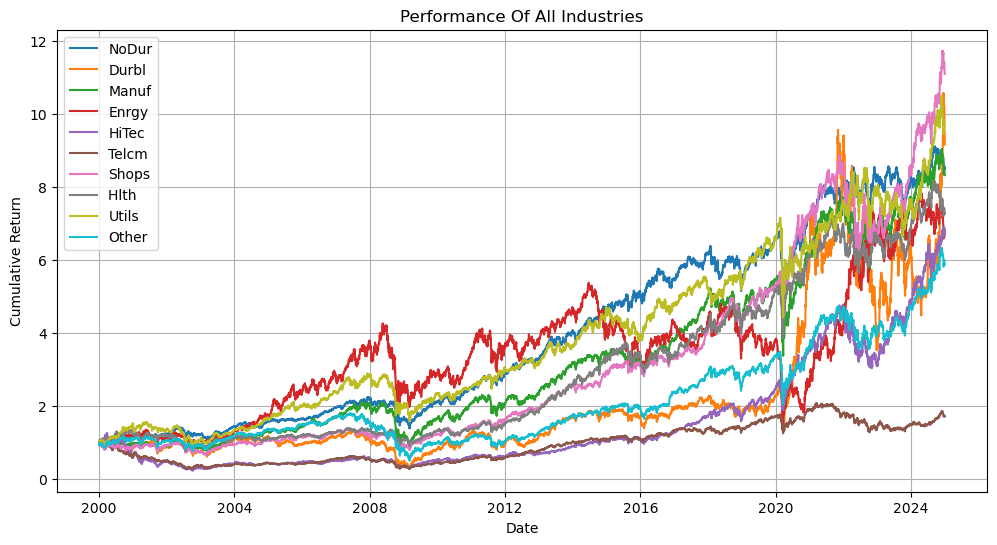

In [5]:
cumulative_returns: pd.DataFrame = (1 + data).cumprod()

plt.figure(figsize=(12, 6))
for column in data.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[column], label=column)

plt.title("Performance Of All Industries")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()

<h3>Show the top 3 best/worst performing industries</h3>

In [6]:
best_performing: pd.Series = cumulative_returns.iloc[-1, :].nlargest(3) - 1
worst_performing: pd.Series = cumulative_returns.iloc[-1, :].nsmallest(3) - 1
print(f'Best performing industries (%): \n{best_performing * 100}\n')
print(f'Worst performing industries (%): \n{worst_performing * 100}')

Best performing industries (%): 
Shops    1010.478100
Utils     868.536773
Durbl     816.765595
Name: 2024-12-31 00:00:00, dtype: float64

Worst performing industries (%): 
Telcm     71.655364
Other    488.724259
HiTec    565.980148
Name: 2024-12-31 00:00:00, dtype: float64


<h3>Show the average CAGR over all industries</h3>

In [7]:
def calc_cagr(portfolio_values: list[float], trading_days_per_year: int = 252) -> float:
    """
    Calculates the Compound Annual Growth Rate (CAGR) of a portfolio.

    Parameters:
    - portfolio_values (list[float]): A list of portfolio values at each time period.
    - trading_days_per_year (int): The number of trading days in a year (default is 252 for a typical year).

    Returns:
    - float: The CAGR of the portfolio.
    """
    cagr: float = (portfolio_values[-1] / portfolio_values[0]) ** (1 / (len(portfolio_values) / trading_days_per_year)) - 1
    return cagr

all_cagr: list[float] = []
for col in data.columns:
    all_cagr.append(calc_cagr(cumulative_returns[col].tolist()))
print(f'Average annualized return of all industries: {np.mean(all_cagr)}')

Average annualized return of all industries: 0.08120443598802804


<h3>Show the average volatility over all industries</h3>

In [8]:
all_volatility: list[float] = []
all_volatility_df: pd.DataFrame = pd.DataFrame()
for col in data.columns:
    all_volatility.append(data[col].std() * np.sqrt(252))
    all_volatility_df[col] = [all_volatility[-1]]
    
print(f'Average annualized volatility of all industries: {np.mean(all_volatility)}\n')
print(f'Industries with the highest volatility: \n{all_volatility_df.transpose().nlargest(3, columns=0)}\n')
print(f'Industries with the smallest volatility: \n{all_volatility_df.transpose().nsmallest(3, columns=0)}')

Average annualized volatility of all industries: 0.22315727102162725

Industries with the highest volatility: 
              0
Durbl  0.312697
Enrgy  0.285494
HiTec  0.264657

Industries with the smallest volatility: 
              0
NoDur  0.151867
Hlth   0.180523
Utils  0.190375


<h3>Check for stationarity</h3>

In [9]:
def check_stationarity(dataset: pd.DataFrame, critical_value: float = 0.05, verbose: bool = True, return_result: bool = False) -> None | list[bool]:
    """
    This function checks the stationarity of each column in a given pandas DataFrame using the Augmented Dickey-Fuller (ADF) test.
    
    Parameters:
    dataset (pd.DataFrame): The DataFrame containing the time series data. Each column represents a different time series.
    critical_value (float, optional): The critical value for the ADF test. If the p-value is less than this value, the time series is considered stationary. Default is 0.05.
    verbose (bool, optional): If True, the function will print a message for each non-stationary column. Default is True.
    return_result (bool, optional): If True, the function will return a list of boolean values indicating the stationarity of each column. Default is False.
    
    Returns:
    None: If return_result is False and all columns are stationary.
    list[bool]: A list of boolean values indicating the stationarity of each column. If return_result is True.
    """
    result: list[bool] = []
    for col in dataset.columns:
        try:
            dftest: tuple = adfuller(dataset[col], autolag='AIC')
            stationary: bool = dftest[1] < critical_value
            if verbose and not stationary:
                print(f"Column '{col}' is not stationary (p-value: {dftest[1]:.4f})")
            result.append(stationary)
        except Exception as e:
            print(f"Unable to check stationarity for column '{col}': {e}")
    
    if False not in result:
        print('All columns in the dataset are stationary.')
    
    if return_result:
        return result

check_stationarity(data)

All columns in the dataset are stationary.


<h3>Function to download the current risk free rate<h3>

In [10]:
def download_risk_free_rate(start: datetime = None, end: datetime = None) -> pd.DataFrame:
    """
    Downloads the risk-free rate data from Yahoo Finance.

    Parameters:
    - start (datetime, optional): The start date for the data retrieval. If not provided, defaults to one year ago from the current date.
    - end (datetime, optional): The end date for the data retrieval. If not provided, defaults to the current date.

    Returns:
    pd.DataFrame: A pandas DataFrame containing the risk-free rate data, with the 'Close' column representing the rate as a decimal value.
    """
    if start is None:
        start = datetime.datetime.now() - datetime.timedelta(days=365)
    if end is None:
        end = datetime.datetime.now()
        
    tnx_data: pd.DataFrame = yf.download('^TNX', start=start, end=end)
    tnx_data.drop(['Open', 'High', 'Low', 'Volume'], axis=1, inplace=True)
    tnx_data['Close'] = tnx_data['Close'] / 100
    return tnx_data

tnx_data: pd.DataFrame = download_risk_free_rate(start=start, end=end)
tnx_data.describe()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price         Close
Ticker         ^TNX
count   6283.000000
mean       0.032726
std        0.013036
min        0.004990
25%        0.021975
50%        0.033010
75%        0.042690
max        0.067810

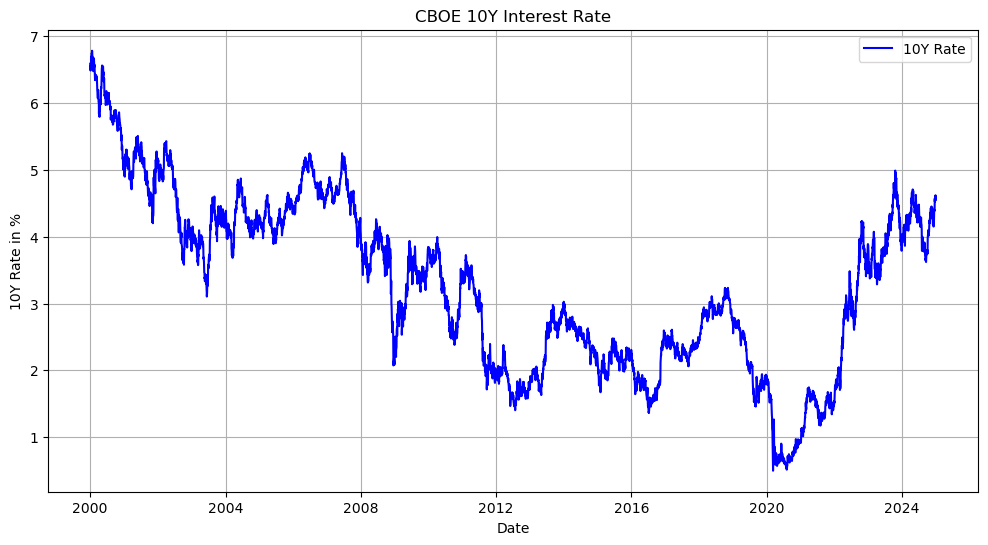

In [11]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()
ax.plot(tnx_data * 100, color='b', label='10Y Rate')
ax.set_title('CBOE 10Y Interest Rate')
ax.set_ylabel('10Y Rate in %')
ax.set_xlabel('Date')
ax.grid()
ax.legend()

<h3>Function for retrieving the risk free rate for a given date</h3>

In [12]:
def get_risk_free_rate(date: str = None) -> float:
    """
    Retrieves the risk-free rate for a specific date or the latest available date.

    Parameters:
    - date (str, optional): The date for which to retrieve the risk-free rate. If not provided, returns the latest available rate.

    Returns:
    float: The risk-free rate as a decimal value for the specified date or the latest available date.
    """
    if date is None:
        return float(tnx_data['Close'].iloc[-1])
    return float(tnx_data.loc[date, 'Close'].values[0])

<h3>Function for calculating portfolio return, volatility and Sharpe ratio</h3>

In [13]:
def calc_portfolio_return(weights: np.array, mean_returns: np.array, regularization: str = 'none', regularization_strength: float = 0.1, return_negative: bool = False) -> float:
    """
    Calculates the portfolio return based on the given weights and mean returns.
    It also applies regularization techniques (L1 and L2) to the portfolio return.
    
    Parameters:
    - weights (np.array): An array of weights for each asset in the portfolio.
    - mean_returns (np.array): An array of mean returns for each asset in the portfolio.
    - regularization (str): The type of regularization to be applied. Default is 'none'.
    - regularization_strength (float): The strength of the regularization. Default is 0.1.
    - return_negative (bool): If True, the function returns the negative portfolio return for optimization purposes. Default is False.
    
    Returns:
    - float: The calculated portfolio return after applying regularization (if any) and considering the return_negative flag.
    """
    
    # Check for valid regularization techniques.
    if regularization.lower() not in ['none', 'l1', 'l2']:
        raise ValueError(f'Unsupported regularization type: {regularization}. Please use one of the following regularizations: \n"none" - no regularization is used \n "l1" regularization is used \n "l2" regularization is used')
    
    # Calculate the portfolio return
    portfolio_return: float = np.dot(weights, mean_returns)
    
    # If regularization is used, the term is subtracted from the portfolio return, since returns should be maximized and the term should act as a penalty.
    if regularization.lower() == 'l1':
        regularization_term: float = np.sum(np.abs(weights))
        portfolio_return -= regularization_strength * regularization_term * (1 / len(weights))
        
    if regularization.lower() == 'l2':
        regularization_term: float = np.sum(weights**2)
        portfolio_return -= regularization_strength * regularization_term * (1 / len(weights))
    
    # Return the negative value if function is used for optimization (scipy.optimize minimizes a function).
    return portfolio_return * -1 if return_negative else portfolio_return

def calc_portfolio_volatility(weights: np.array, cov_matrix: np.array, regularization: str = 'none', regularization_strength: float = 0.1, return_negative: bool = False) -> float:
    """
    Calculates the portfolio volatility with the possibility of using L1 or L2 regularization.
    
    Parameters:
    - weights (np.array): An array representing the weights of the assets in the portfolio.
    - cov_matrix (np.array): A 2D array representing the covariance matrix of the assets.
    - regularization (str): A string representing the type of regularization to be used. It can be 'none', 'l1', or 'l2'. Default is 'none'.
    - regularization_strength (float): A float representing the strength of the regularization. Default is 0.1.
    - return_negative (bool): A boolean indicating whether to return the negative value of the portfolio volatility. Default is False.
    
    Returns:
    - float: The portfolio volatility. If return_negative is True, the negative value of the portfolio volatility is returned.
    """
    
    # Check for valid regularization techniques.
    if regularization.lower() not in ['none', 'l1', 'l2']:
        raise ValueError(f'Unsupported regularization type: {regularization}. Please use one of the following regularizations: \n"none" - no regularization is used \n "l1" regularization is used \n "l2" regularization is used')
    
    # Calculate the portfolio volatility
    portfolio_volatility: float = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    # If regularization is used, the term is added to the portfolio volatility, since volatility should be minimized and the term should act as a penalty.
    if regularization.lower() == 'l1':
        regularization_term: float = np.sum(np.abs(weights))
        portfolio_volatility += regularization_strength * regularization_term * (1 / len(weights))
        
    if regularization.lower() == 'l2':
        regularization_term: float = np.sum(weights**2)
        portfolio_volatility += regularization_strength * regularization_term * (1 / len(weights))
    
    # Return the negative value if function is used for optimization (scipy.optimize minimizes a function).
    return portfolio_volatility * -1 if return_negative else portfolio_volatility
    
def calc_portfolio_sharpe_ratio(weights: np.array, mean_returns: np.array, cov_matrix: np.array, risk_free_rate: float, regularization: str = 'none', regularization_strength: float = 0.1, days_per_year: int = 252, return_negative: bool = False) -> float:
    """
    Calculates the portfolio Sharpe ratio, taking into account the specified regularization technique.
    
    Parameters:
    - weights (np.array): An array representing the weights of the assets in the portfolio.
    - mean_returns (np.array): An array representing the mean returns of the assets.
    - cov_matrix (np.array): A 2D array representing the covariance matrix of the assets.
    - risk_free_rate (float): The risk-free rate of return.
    - regularization (str): The type of regularization to be used. It can be 'none', 'l1', or 'l2'. Default is 'none'.
    - regularization_strength (float): The strength of the regularization. Default is 0.1.
    - days_per_year (int): The number of trading days in a year. Default is 252.
    - return_negative (bool): If True, the function returns a negative Sharpe ratio. Default is False.
    
    Returns:
    - float: The portfolio Sharpe ratio, taking into account the specified regularization technique. If return_negative is True, the Sharpe ratio is returned as a negative value.
    """
    
    # Check for valid regularization techniques.
    if regularization.lower() not in ['none', 'l1', 'l2']:
        raise ValueError(f'Unsupported regularization type: {regularization}. Please use one of the following regularizations: \n"none" - no regularization is used \n "l1" regularization is used \n "l2" regularization is used')
        
    # Calculate the portfolio Sharpe ratio
    portfolio_return: float = calc_portfolio_return(weights, mean_returns, regularization_strength=0) * days_per_year
    portfolio_volatility: float = calc_portfolio_volatility(weights, cov_matrix, regularization_strength=0) * np.sqrt(days_per_year)
    sharpe_ratio: float = (portfolio_return - risk_free_rate) / portfolio_volatility
        
    # If regularization is used, the term is subtracted from the portfolio Sharpe ratio, since the Sharpe ratio should be maximized and the term should act as a penalty.
    if regularization.lower() == 'l1':
        regularization_term: float = np.sum(np.abs(weights))
        sharpe_ratio -= regularization_strength * regularization_term * (1 / len(weights))
        
    if regularization.lower() == 'l2':
        regularization_term: float = np.sum(weights**2)
        sharpe_ratio -= regularization_strength * regularization_term * (1 / len(weights))
            
    return sharpe_ratio * -1 if return_negative else sharpe_ratio


<h3>Function for generating randomly distributed initial weigths</h3>

In [14]:
def generate_random_weights(num_assets: int) -> np.array:
    """
    Generate random weights for a portfolio with a given number of assets.
    
    The weights are generated using a Dirichlet distribution with all concentration parameters set to 1.
    This results in weights that are uniformly distributed and sum up to 1.
    
    Parameters:
    num_assets (int): The number of assets in the portfolio.
    
    Returns:
    np.array: An array of random weights, where each weight represents the proportion of the portfolio's value in a specific asset.
    """
    return np.random.dirichlet(np.ones(num_assets), size=1).flatten()

<h3>Function for calibrating the weights to find the minimum variance portfolio, the optimal portfolio (maximum Sharpe ratio) and the maximum return portfolio</h3>

In [15]:
def calc_weights_for_portfolio(portfolio_type: str, historic_returns: pd.DataFrame, regularization: str = 'none', regularization_strength: float = 0.1, 
                               allow_short_positions: bool = True, max_volatility_for_maximum_return_portfolio: float = 2, days_per_year: int = 252, 
                               method: str = 'SLSQP', date: str = None, verbose: bool = True) -> tuple[np.array, float, float, float]:
    """
    Calculates the optimal weights for a given portfolio type based on historical returns.

    Parameters:
    portfolio_type (str): The type of portfolio to optimize. It can be one of 'minimum_variance', 'maximum_return', 'maximum_sharpe_ratio' or 'naive'.
    historic_returns (pd.DataFrame): A DataFrame containing historical returns of assets.
    regularization (str): The type of regularization to apply. It can be 'none', 'l1', or 'l2'.
    regularization_strength (float): The strength of the regularization.
    allow_short_positions (bool): Whether to allow short positions in the portfolio.
    max_volatility_for_maximum_return_portfolio (float): The maximum volatility allowed for the maximum return portfolio.
    days_per_year (int): The number of trading days in a year.
    method (str): The optimization method to use.
    date (str): The date for which to retrieve the risk-free rate.
    verbose (bool): Whether to print verbose output.

    Returns:
    tuple[np.array, float, float, float]: A tuple containing the optimal weights, portfolio return, portfolio volatility, and portfolio Sharpe ratio.
    """
    if portfolio_type.lower() not in ['minimum_variance', 'maximum_return', 'maximum_sharpe_ratio', 'naive']:
        raise ValueError(f'Unsupported portfolio type: {portfolio_type}. Please use one of the following portfolio types: \n"minimum_variance" - minimum variance portfolio \n"maximum_sharpe_ratio" - maximum Sharpe ratio portfolio \n"maximum_return" - maximum return portfolio')
    
    num_assets: int = len(historic_returns.columns)
    mean_returns: np.array = historic_returns.mean().values
    cov_matrix: np.array = historic_returns.cov().values
    risk_free_rate: float = get_risk_free_rate(date=date)
    
    # A single weight for an asset can be anywhere between -1 and 1
    if allow_short_positions:
        bounds: tuple[float] = tuple((-1, 1) for _ in range(num_assets))
    else:
        bounds: tuple[float] = tuple((0, 1) for _ in range(num_assets))
    # Initially weights are distributed equally:
    initial_weights: list[float] = num_assets * [1 / num_assets]
    # When random weights are generated, the minimum variance portfolio is unstable and tends to converge into a local minima.
    # initial_weights: list[float] = generate_random_weights(num_assets)
    
    options: dict = {'maxiter': 100_000}
    
    # Weights must sum up to 1:
    weight_constraint: dict = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
    # Weights must sum up to at least 1:
    weight_constraint_min: dict = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
    # Volatility constraint
    volatility_constraint: dict = {'type': 'ineq', 'fun': lambda weights: max_volatility_for_maximum_return_portfolio - np.sqrt(weights.T @ cov_matrix @ weights * days_per_year)}
    # Constraint: Weights must sum to 1
    def constraint_penalty(weights):
        return 1000 * abs(np.sum(weights) - 1)  # Large penalty if sum ≠ 1    
    
    # Solve for the minimum variance portfolio
    if portfolio_type.lower() =='minimum_variance':
        args: tuple[np.array | float] = (cov_matrix, regularization, regularization_strength, False)
        if method == 'differential_evolution':
            objective: function = lambda weights: calc_portfolio_volatility(weights, cov_matrix, regularization, regularization_strength, return_negative=True) + constraint_penalty(weights)
            result: OptimizeResult = differential_evolution(objective, bounds=bounds, maxiter=options['maxiter'], tol=1e-2)
        else:
            constraints: list[dict] = [weight_constraint_min]
            result: OptimizeResult = minimize(calc_portfolio_volatility, initial_weights, args=args, method=method, bounds=bounds, constraints=constraints, options=options)  
        
    # Solve for the maximum return portfolio
    if portfolio_type.lower() =='maximum_return':
        constraints: list[dict] = [volatility_constraint]
        args: tuple[np.array | float] = (mean_returns, regularization, regularization_strength, True)
        result: OptimizeResult = minimize(calc_portfolio_return, initial_weights, args=args, method=method, bounds=bounds, constraints=constraints, options=options)
    
    # Solve for the maximum Sharpe ratio portfolio
    if portfolio_type.lower() =='maximum_sharpe_ratio':
        args: tuple[np.array | float] = (mean_returns, cov_matrix, risk_free_rate, regularization, regularization_strength, days_per_year, True)
        constraints: list[dict] = [weight_constraint]
        result: OptimizeResult = minimize(calc_portfolio_sharpe_ratio, initial_weights, args=args, method=method, bounds=bounds, constraints=constraints, options=options)
    
    # if not result.success:
    #     raise Exception('Optimization failed: ' + result.message)
    
    portfolio_weights: np.array = result.x if portfolio_type != 'naive' else np.array([1 / len(mean_returns) for _ in range(len(mean_returns))])
    portfolio_return: float = calc_portfolio_return(portfolio_weights, mean_returns, regularization, 0, return_negative=False) * days_per_year
    portfolio_volatility: float = calc_portfolio_volatility(portfolio_weights, cov_matrix, regularization, 0, return_negative=False) * np.sqrt(days_per_year)
    portfolio_sharpe_ratio: float = calc_portfolio_sharpe_ratio(portfolio_weights, mean_returns, cov_matrix, risk_free_rate, regularization, 0, days_per_year, return_negative=False)
    
    if verbose:
        print('*' * 25)
        print(f'Portfolio type: {portfolio_type}')
        # print(f'Regularization: {regularization} Strength: {regularization_strength}')
        # print(f'Optimal weights: {portfolio_weights}')
        print(f'Portfolio return: {portfolio_return * 100:.4f}%')
        print(f'Portfolio volatility: {portfolio_volatility * 100:.4f}%')
        print(f'Portfolio Sharpe ratio: {portfolio_sharpe_ratio:.4f}')
        print(f'Iterations: {result.nit if portfolio_type.lower() != 'naive' else '0'}')
        print(f'Largest positions: \n-Long: {round(max(portfolio_weights), 2)} \n-Short: {round(min(portfolio_weights), 2)} \nSum weights: {sum(portfolio_weights)}')
        
    return [portfolio_weights, portfolio_return, portfolio_volatility, portfolio_sharpe_ratio]

<h3>Function for tracking the portfolio performance with rebalancing using the weights from the past / Backtesting</h3>

In [16]:
def calc_sortino_ratio(returns: np.array, risk_free_rate: float = 0, target_return: float = 0, days_per_year: int = 252) -> float:
    """
    Calculates the Sortino ratio based on a series of returns.
    
    The Sortino ratio is a modification of the Sharpe ratio that only considers 
    downside risk (negative returns below a target return), rather than total volatility.
    
    Parameters:
    - returns (np.array): An array of returns to calculate the Sortino ratio from.
    - risk_free_rate (float): The risk-free rate of return (daily rate). Default is 0.
    - target_return (float): The target or minimum acceptable return (daily rate). Default is 0.
    - days_per_year (int): The number of trading days in a year for annualization. Default is 252.
    
    Returns:
    - float: The annualized Sortino ratio.
    """
    # Calculate excess returns over the target return
    excess_returns = returns - target_return
    
    # Calculate mean excess return
    mean_excess_return = np.mean(excess_returns)
    
    # Calculate downside deviation - only negative returns below target
    negative_returns = excess_returns[excess_returns < 0]
    
    # If there are no negative returns, return a very high value or handle appropriately
    if len(negative_returns) == 0:
        return float('inf')  # Perfect scenario with no downside risk
    
    # Calculate downside deviation
    downside_deviation = np.sqrt(np.mean(negative_returns**2))
    
    # Calculate and return the annualized Sortino ratio
    sortino_ratio = (mean_excess_return - risk_free_rate) / downside_deviation * np.sqrt(days_per_year)
    
    return sortino_ratio

def track_portfolio_performance(portfolio_type: str, data: pd.DataFrame, rebalance_freq: int = 63, lookback_period: int = 252, regularization: str = 'none', regularization_strength: float = 0.1, allow_short_positions: bool = False, days_per_year: int = 252) -> tuple[list[float], list[int], list[float], list[list[float]], list[float], list[float], list[float]]:
    """
    Tracks the performance of a portfolio by rebalancing the portfolio weights at regular intervals.
    
    Parameters:
    - portfolio_type (str): The type of portfolio ('naive', 'minimum_variance', 'maximum_sharpe_ratio', 'maximum_return').
    - data (pd.DataFrame): A DataFrame containing the historical stock prices.
    - rebalance_freq (int): The frequency of rebalancing the portfolio in days (default is 63 for 3 months).
    - lookback_period (int): The number of days used to determine optimal weights (default is 252 for 1 year).
    - regularization (str): The type of regularization to use (default is 'none').
    - regularization_strength (float): The strength of the regularization (default is 0.1).
    - allow_short_positions (bool): Whether to allow short positions (default is False).
    - days_per_year (int): The number of trading days in a year (default is 252 for a typical year).
    
    Returns:
    - portfolio_values (list[float]): A list containing the portfolio values at each rebalancing date.
    - rebalance_dates (list[int]): A list containing the indices of the rebalancing dates in the input data.
    - portfolio_sharpe_ratio (list[float]): A list containing the portfolio sharpe ratios at each rebalancing date based on actual performance. 
    - weights (list[list[float]]): A list containing lists for the portfolio weights for each asset at each rebalancing date.
    - portfolio_volatility (list[float]): A list containing the portfolio volatilities at each rebalancing date based on actual performance.
    - portfolio_sortino_ratio (list[float]): A list containing the portfolio Sortino ratios at each rebalancing date based on actual performance.
    - period_returns (list[float]): A list containing the total returns for each rebalancing period.
    """
    rebalance_dates: list[int] = []
    portfolio_values: list[float] = [1.0]  # Start with initial portfolio value of 1.0
    portfolio_volatility: list[float] = []
    portfolio_sharpe_ratio: list[float] = []
    portfolio_sortino_ratio: list[float] = []
    portfolio_weights: list[list[float]] = []
    period_returns: list[float] = []  # New list to store returns for each period
    
    # We cannot start tracking performance until we have at least `lookback_period` data points
    start_idx = lookback_period
    num_periods = (len(data) - start_idx) // rebalance_freq  # Adjust the number of periods to exclude the initial data

    weights = None
    risk_free_rate = 0  # Default risk-free rate, can be modified to use get_risk_free_rate()
    
    for i in range(num_periods + 1):
        # The start and end indices for the current rebalancing period
        current_start_idx = start_idx + i * rebalance_freq
        current_end_idx = current_start_idx + rebalance_freq
        
        # Ensure we don't exceed the data length
        if current_end_idx > len(data):
            current_end_idx = len(data)

        # Use the last lookback_period of data for the weights calculation
        historic_data_start_idx = max(0, current_start_idx - lookback_period)
        
        # Rebalance every `rebalance_freq` days (63 for 3 months)
        if current_start_idx == start_idx or i % 1 == 0:  # Rebalance at each `rebalance_freq` step
            # Use the historic data to calculate the weights
            historic_data = data.iloc[historic_data_start_idx:current_start_idx]
            weights, _, _, _ = calc_weights_for_portfolio(
                portfolio_type, 
                historic_data, 
                regularization=regularization, 
                regularization_strength=regularization_strength, 
                allow_short_positions=allow_short_positions, 
                days_per_year=days_per_year, 
                date=str(data.index[current_start_idx])[0:10], 
                verbose=False
            )
            rebalance_dates.append(current_start_idx)
        
        # Calculate portfolio returns for the current period
        period_data = data.iloc[current_start_idx:current_end_idx]
        daily_portfolio_returns = period_data @ weights
        
        # Calculate the total return for this period
        if len(daily_portfolio_returns) > 0:
            period_total_return = (1 + daily_portfolio_returns).prod() - 1
            period_returns.append(period_total_return * 100)
        
        # Update portfolio values
        period_portfolio_values = (1 + daily_portfolio_returns).cumprod() * portfolio_values[-1]
        portfolio_values.extend(period_portfolio_values)
        portfolio_weights.append(weights)
        
        # Calculate actual volatility, Sharpe ratio, and Sortino ratio based on realized returns
        # Only calculate if we have enough data points
        if len(daily_portfolio_returns) >= 20:  # Use at least 20 days of data for meaningful statistics
            # Convert risk-free rate to daily rate if it's an annual rate
            daily_risk_free_rate = (1 + risk_free_rate) ** (1/days_per_year) - 1
            
            # Calculate volatility (standard deviation of returns) and annualize it
            actual_volatility = daily_portfolio_returns.std() * np.sqrt(days_per_year) * 100  # Convert to percentage
            portfolio_volatility.append(actual_volatility)
            
            # Calculate Sharpe ratio (mean return / std of returns) and annualize it
            actual_sharpe_ratio = (daily_portfolio_returns.mean() - daily_risk_free_rate) / daily_portfolio_returns.std() * np.sqrt(days_per_year)
            portfolio_sharpe_ratio.append(actual_sharpe_ratio)
            
            # Calculate Sortino ratio using the specified function
            actual_sortino_ratio = calc_sortino_ratio(
                daily_portfolio_returns.values, 
                risk_free_rate=daily_risk_free_rate,
                target_return=0,  # Using 0 as the minimum acceptable return
                days_per_year=days_per_year
            )
            portfolio_sortino_ratio.append(actual_sortino_ratio)
        else:
            # If we don't have enough data yet, use placeholders
            portfolio_volatility.append(None)
            portfolio_sharpe_ratio.append(None)
            portfolio_sortino_ratio.append(None)
            if len(period_returns) > 0:
                period_returns.pop()  # Remove the last period return if we don't have enough data
                period_returns.append(None)
        
    return portfolio_values, rebalance_dates, portfolio_sharpe_ratio, portfolio_weights, portfolio_volatility, portfolio_sortino_ratio, period_returns

<h3>Plot the performance / backtest of the minimum variance, maximum Sharpe ratio and naive portfolio without regularization</h3>

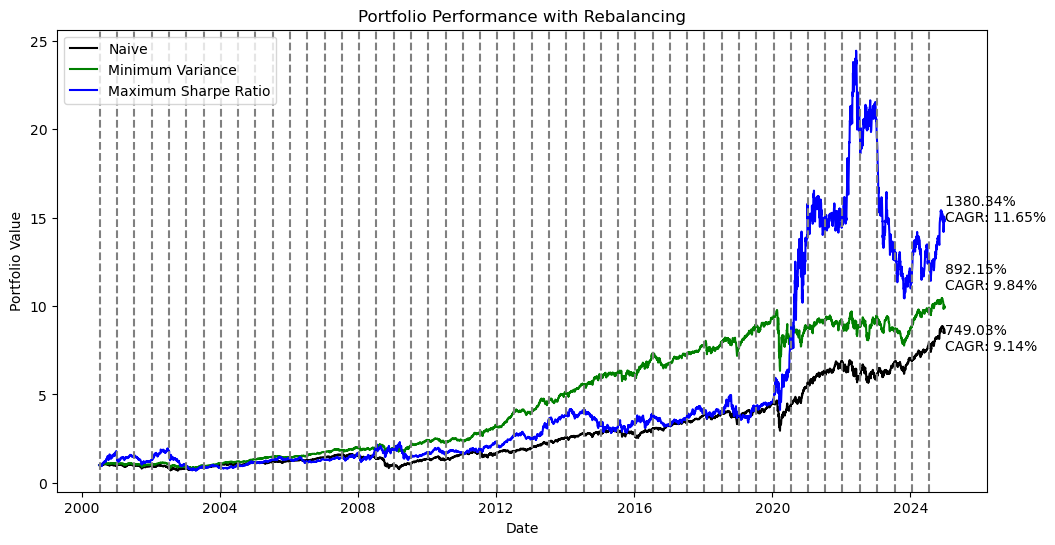

In [17]:
rebalancing_every_n_days: int = int(252/2)
days_used_to_determine_optimal_weights: int = int(0.5 * 252)
allow_short_positions: bool = True

rebalancing_dates: list[int] = []

naive_portfolio_performances: list[float] = []
naive_portfolio_sharpe_ratio: list[float] = []
naive_portfolio_portfolio_volatility: list[float] = []
naive_portfolio_sortino_ratio: list[float] = []
naive_portfolio_period_returns: list[float] = []

minimum_variance_portfolio_performance: list[float] = []
minimum_variance_portfolio_sharpe_ratio: list[float] = []
minimum_variance_portfolio_volatility: list[float] = []
minimum_variance_portfolio_sortino_ratio: list[float] = []
minimum_variance_portfolio_period_returns: list[float] = []

maximum_sharpe_ratio_portfolio_performance: list[float] = []
maximum_sharpe_ratio_portfolio_sharpe_ratio: list[float] = []
maximum_sharpe_ratio_portfolio_portfolio_volatility: list[float] = []
maximum_sharpe_ratio_portfolio_sortino_ratio: list[float] = []
maximum_sharpe_ratio_portfolio_period_returns: list[float] = []

# maximum_return_portfolio_performance: list[float] = []

naive_portfolio_performance, _, naive_portfolio_sharpe_ratio, naive_portfolio_weights, naive_portfolio_portfolio_volatility, naive_portfolio_sortino_ratio, naive_portfolio_period_returns = track_portfolio_performance('naive', data, rebalance_freq=rebalancing_every_n_days, lookback_period=days_used_to_determine_optimal_weights, allow_short_positions=allow_short_positions)
naive_portfolio_portfolio_cagr: float = calc_cagr(naive_portfolio_performance)

minimum_variance_portfolio_performance, rebalancing_dates, minimum_variance_portfolio_sharpe_ratio, minimum_variance_portfolio_weights, minimum_variance_portfolio_volatility, minimum_variance_portfolio_sortino_ratio, minimum_variance_portfolio_period_returns = track_portfolio_performance('minimum_variance', data, rebalance_freq=rebalancing_every_n_days, lookback_period=days_used_to_determine_optimal_weights, allow_short_positions=allow_short_positions)
minimum_variance_portfolio_cagr: float = calc_cagr(minimum_variance_portfolio_performance)

maximum_sharpe_ratio_portfolio_performance, _, maximum_sharpe_ratio_portfolio_sharpe_ratio, maximum_sharpe_ratio_portfolio_weights, maximum_sharpe_ratio_portfolio_portfolio_volatility, maximum_sharpe_ratio_portfolio_sortino_ratio, maximum_sharpe_ratio_portfolio_period_returns = track_portfolio_performance('maximum_sharpe_ratio', data, rebalance_freq=rebalancing_every_n_days, lookback_period=days_used_to_determine_optimal_weights, allow_short_positions=allow_short_positions)
maximum_sharpe_ratio_portfolio_cagr: float = calc_cagr(maximum_sharpe_ratio_portfolio_performance)

# maximum_return_portfolio_performance, _ = track_portfolio_performance('maximum_return', data, rebalance_freq=rebalancing_every_n_days, lookback_period=days_used_to_determine_optimal_weights, allow_short_positions=allow_short_positions)
# maximum_return_portfolio_cagr: float = calc_cagr(maximum_return_portfolio_performance)

date_list: list[pd.Timestamp] = data.index.tolist()
min_date: pd.Timestamp = min(date_list)
previous_date: pd.Timestamp = min_date - pd.Timedelta(days=1)
date_list.insert(0, previous_date)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()

ax.plot(date_list[days_used_to_determine_optimal_weights:], naive_portfolio_performance, color='black', label='Naive')
ax.text(max(date_list), naive_portfolio_performance[-1] - 1, f'{round((naive_portfolio_performance[-1] -1) * 100, 2)}% \nCAGR: {round(naive_portfolio_portfolio_cagr * 100, 2)}%')

ax.plot(date_list[days_used_to_determine_optimal_weights:], minimum_variance_portfolio_performance, color='g', label='Minimum Variance')
ax.text(max(date_list), minimum_variance_portfolio_performance[-1] + 1, f'{round((minimum_variance_portfolio_performance[-1] -1) * 100, 2)}% \nCAGR: {round(minimum_variance_portfolio_cagr * 100, 2)}%')

ax.plot(date_list[days_used_to_determine_optimal_weights:], maximum_sharpe_ratio_portfolio_performance, color='b', label='Maximum Sharpe Ratio')
ax.text(max(date_list), maximum_sharpe_ratio_portfolio_performance[-1], f'{round((maximum_sharpe_ratio_portfolio_performance[-1] -1) * 100, 2)}% \nCAGR: {round(maximum_sharpe_ratio_portfolio_cagr * 100, 2)}%')

# ax.plot(date_list[days_used_to_determine_optimal_weights:], maximum_return_portfolio_performance, color='r', label='Maximum Return')
# ax.text(max(date_list), maximum_return_portfolio_performance[-1], f'{round((maximum_return_portfolio_performance[-1] -1) * 100, 2)}% \nCAGR: {round(maximum_return_portfolio_cagr * 100, 2)}%')

for rebalancing_date in rebalancing_dates:
    ax.axvline(date_list[rebalancing_date + 1], color='gray', ls='--')
ax.set_xlabel('Date')
ax.set_ylabel('Portfolio Value')
ax.set_title('Portfolio Performance with Rebalancing')
ax.legend(loc='upper left')

<h3>Show the changes in portfolio weights over time</h3>

Minimum Variance Portfolio Weights Volatility: 0.19199174425435672
Maximum Sharpe Ratio Portfolio Weights Volatility: 0.6467930356724008


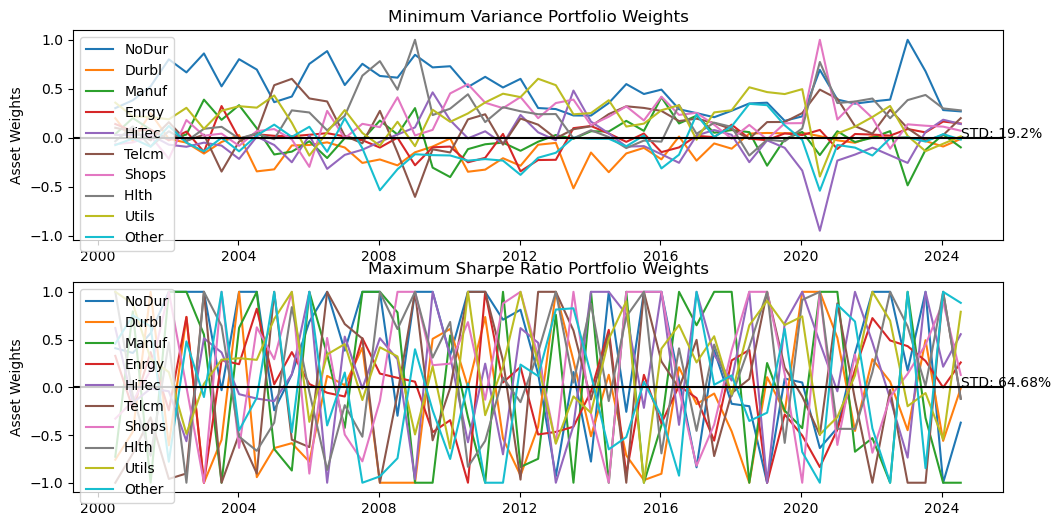

In [18]:
asset_volatilities: list[float] = []
for i in range(len(minimum_variance_portfolio_weights[1])):
    asset_weights: list[float] = []
    for j in range(len(minimum_variance_portfolio_weights)):
        asset_weights.append(minimum_variance_portfolio_weights[j][i])
    asset_volatilities.append(np.std(asset_weights))
minimum_variance_portfolio_weights_std: float = np.mean(asset_volatilities)

asset_volatilities: list[float] = []
for i in range(len(maximum_sharpe_ratio_portfolio_weights[1])):
    asset_weights: list[float] = []
    for j in range(len(maximum_sharpe_ratio_portfolio_weights)):
        asset_weights.append(maximum_sharpe_ratio_portfolio_weights[j][i])
    asset_volatilities.append(np.std(asset_weights))
maximum_sharpe_ratio_portfolio_weights_std: float = np.mean(asset_volatilities)

print(f'Minimum Variance Portfolio Weights Volatility: {minimum_variance_portfolio_weights_std}')
print(f'Maximum Sharpe Ratio Portfolio Weights Volatility: {maximum_sharpe_ratio_portfolio_weights_std}')

weight_dates: list[pd.Timestamp] = [date_list[i] for i in rebalancing_dates]


fig, axes = plt.subplots(2, 1, figsize=(12, 6))

axes[0].set_title('Minimum Variance Portfolio Weights')
axes[0].set_ylabel('Asset Weights')
axes[0].plot(weight_dates, minimum_variance_portfolio_weights, label=data.columns)
axes[0].text(weight_dates[-1], 0, f'STD: {round(minimum_variance_portfolio_weights_std * 100, 2)}%') 
axes[0].axhline(0, color='black')
axes[0].legend(loc='upper left')

axes[1].set_title('Maximum Sharpe Ratio Portfolio Weights')
axes[1].set_ylabel('Asset Weights')
axes[1].plot(weight_dates, maximum_sharpe_ratio_portfolio_weights, label=data.columns) 
axes[1].text(weight_dates[-1], 0, f'STD: {round(maximum_sharpe_ratio_portfolio_weights_std * 100, 2)}%') 
axes[1].axhline(0, color='black')
axes[1].legend(loc='upper left')

<h3>Show the Sharpe ratio over time</h3>

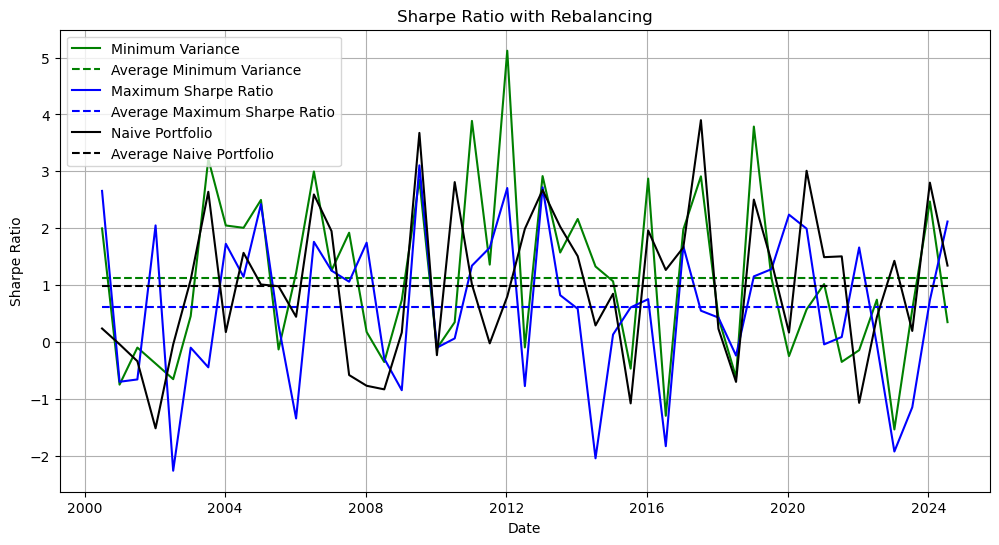

In [19]:
sharpe_ratio_dates: list[pd.Timestamp] = [date_list[i] for i in rebalancing_dates]

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()

ax.plot(sharpe_ratio_dates, minimum_variance_portfolio_sharpe_ratio, color='g', label='Minimum Variance')
ax.plot(sharpe_ratio_dates, [np.mean(minimum_variance_portfolio_sharpe_ratio) for _ in range(len(rebalancing_dates))], color='g', linestyle='--', label='Average Minimum Variance')

ax.plot(sharpe_ratio_dates, maximum_sharpe_ratio_portfolio_sharpe_ratio, color='b', label='Maximum Sharpe Ratio')
ax.plot(sharpe_ratio_dates, [np.mean(maximum_sharpe_ratio_portfolio_sharpe_ratio) for _ in range(len(rebalancing_dates))], color='b', linestyle='--', label='Average Maximum Sharpe Ratio')

ax.plot(sharpe_ratio_dates, naive_portfolio_sharpe_ratio, color='black', label='Naive Portfolio')
ax.plot(sharpe_ratio_dates, [np.mean(naive_portfolio_sharpe_ratio) for _ in range(len(rebalancing_dates))], color='black', linestyle='--', label='Average Naive Portfolio')

ax.set_xlabel('Date')
ax.set_ylabel('Sharpe Ratio')
ax.set_title('Sharpe Ratio with Rebalancing')
ax.legend(loc='upper left')
ax.grid()

<h3>Show the Sortino Ratio</h3>

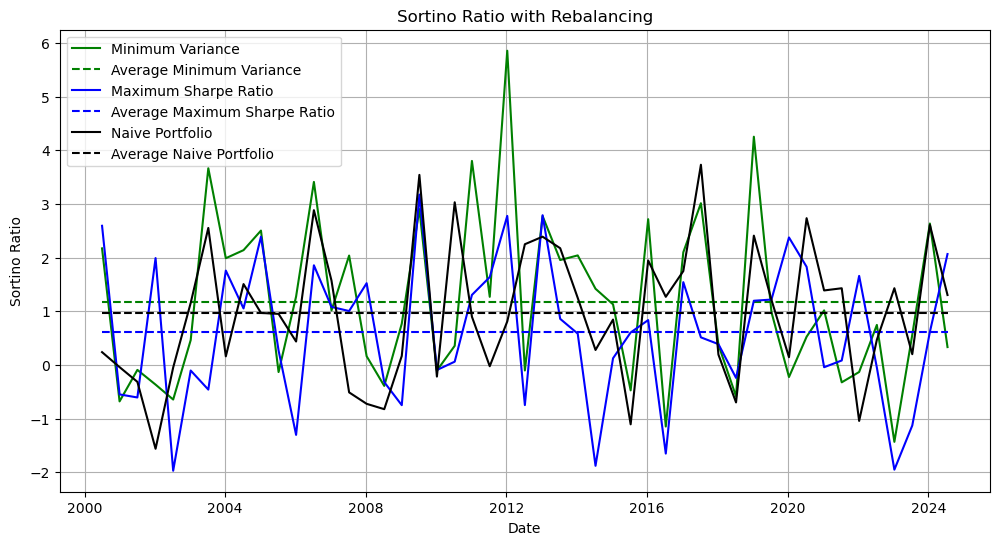

In [20]:
sharpe_ratio_dates: list[pd.Timestamp] = [date_list[i] for i in rebalancing_dates]

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()

ax.plot(sharpe_ratio_dates, minimum_variance_portfolio_sortino_ratio, color='g', label='Minimum Variance')
ax.plot(sharpe_ratio_dates, [np.mean(minimum_variance_portfolio_sortino_ratio) for _ in range(len(rebalancing_dates))], color='g', linestyle='--', label='Average Minimum Variance')

ax.plot(sharpe_ratio_dates, maximum_sharpe_ratio_portfolio_sortino_ratio, color='b', label='Maximum Sharpe Ratio')
ax.plot(sharpe_ratio_dates, [np.mean(maximum_sharpe_ratio_portfolio_sortino_ratio) for _ in range(len(rebalancing_dates))], color='b', linestyle='--', label='Average Maximum Sharpe Ratio')

ax.plot(sharpe_ratio_dates, naive_portfolio_sortino_ratio, color='black', label='Naive Portfolio')
ax.plot(sharpe_ratio_dates, [np.mean(naive_portfolio_sortino_ratio) for _ in range(len(rebalancing_dates))], color='black', linestyle='--', label='Average Naive Portfolio')

ax.set_xlabel('Date')
ax.set_ylabel('Sortino Ratio')
ax.set_title('Sortino Ratio with Rebalancing')
ax.legend(loc='upper left')
ax.grid()

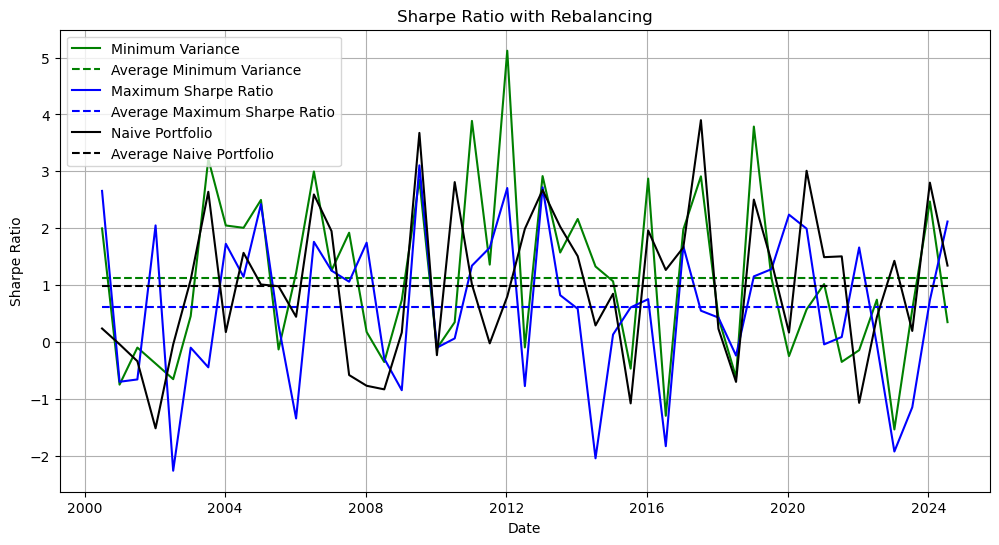

In [21]:
sharpe_ratio_dates: list[pd.Timestamp] = [date_list[i] for i in rebalancing_dates]

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()

ax.plot(sharpe_ratio_dates, minimum_variance_portfolio_sharpe_ratio, color='g', label='Minimum Variance')
ax.plot(sharpe_ratio_dates, [np.mean(minimum_variance_portfolio_sharpe_ratio) for _ in range(len(rebalancing_dates))], color='g', linestyle='--', label='Average Minimum Variance')

ax.plot(sharpe_ratio_dates, maximum_sharpe_ratio_portfolio_sharpe_ratio, color='b', label='Maximum Sharpe Ratio')
ax.plot(sharpe_ratio_dates, [np.mean(maximum_sharpe_ratio_portfolio_sharpe_ratio) for _ in range(len(rebalancing_dates))], color='b', linestyle='--', label='Average Maximum Sharpe Ratio')

ax.plot(sharpe_ratio_dates, naive_portfolio_sharpe_ratio, color='black', label='Naive Portfolio')
ax.plot(sharpe_ratio_dates, [np.mean(naive_portfolio_sharpe_ratio) for _ in range(len(rebalancing_dates))], color='black', linestyle='--', label='Average Naive Portfolio')

ax.set_xlabel('Date')
ax.set_ylabel('Sharpe Ratio')
ax.set_title('Sharpe Ratio with Rebalancing')
ax.legend(loc='upper left')
ax.grid()

In [22]:
np.mean(naive_portfolio_sharpe_ratio)
df_corr = pd.DataFrame({'Minimum Variance': minimum_variance_portfolio_sharpe_ratio, 'Maximum Sharpe Ratio': maximum_sharpe_ratio_portfolio_sharpe_ratio, 'Naive Portfolio': naive_portfolio_sharpe_ratio})
df_corr.corr()

Minimum Variance  Maximum Sharpe Ratio  Naive Portfolio
Minimum Variance              1.000000              0.512587         0.495962
Maximum Sharpe Ratio          0.512587              1.000000         0.170054
Naive Portfolio               0.495962              0.170054         1.000000

<h3>Show the returns over time</h3>

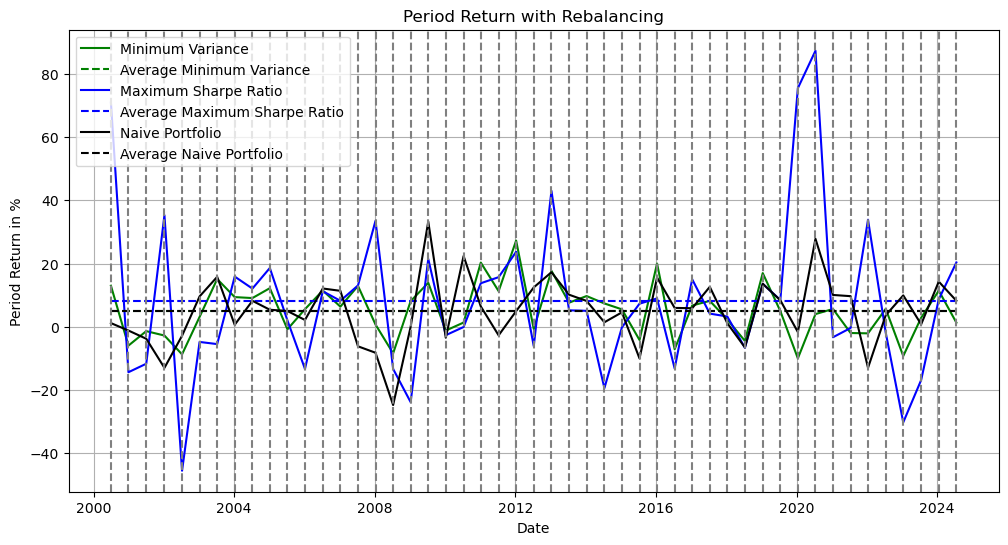

In [23]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()

ax.plot(sharpe_ratio_dates, minimum_variance_portfolio_period_returns, color='g', label='Minimum Variance')
ax.plot(sharpe_ratio_dates, [np.mean(minimum_variance_portfolio_period_returns) for _ in range(len(rebalancing_dates))], color='g', linestyle='--', label='Average Minimum Variance')

ax.plot(sharpe_ratio_dates, maximum_sharpe_ratio_portfolio_period_returns, color='b', label='Maximum Sharpe Ratio')
ax.plot(sharpe_ratio_dates, [np.mean(maximum_sharpe_ratio_portfolio_period_returns) for _ in range(len(rebalancing_dates))], color='b', linestyle='--', label='Average Maximum Sharpe Ratio')

ax.plot(sharpe_ratio_dates, naive_portfolio_period_returns, color='black', label='Naive Portfolio')
ax.plot(sharpe_ratio_dates, [np.mean(naive_portfolio_period_returns) for _ in range(len(rebalancing_dates))], color='black', linestyle='--', label='Average Naive Portfolio')

for date in sharpe_ratio_dates:
    ax.axvline(date, color='gray', linestyle='--')

ax.set_title('Period Return with Rebalancing')
ax.set_xlabel('Date')
ax.set_ylabel('Period Return in %')
ax.legend(loc='upper left')
ax.grid()

In [24]:
print(f'Naively chosen portfolio: {np.mean(naive_portfolio_period_returns)}')
print(f'Minimum variance portfolio: {np.mean(minimum_variance_portfolio_period_returns)}')
print(f'Maximum sharpe ratio portfolio: {np.mean(maximum_sharpe_ratio_portfolio_period_returns)}')

Naively chosen portfolio: 4.975782231321399
Minimum variance portfolio: 5.126333480986926
Maximum sharpe ratio portfolio: 8.221021516819194


In [25]:
min(maximum_sharpe_ratio_portfolio_period_returns)

-45.489524475089304

In [26]:
df_corr = pd.DataFrame({'Minimum Variance': minimum_variance_portfolio_period_returns, 'Maximum Sharpe Ratio': maximum_sharpe_ratio_portfolio_period_returns, 'Naive Portfolio': naive_portfolio_period_returns})
df_corr.corr()

Minimum Variance  Maximum Sharpe Ratio  Naive Portfolio
Minimum Variance              1.000000              0.251778         0.445595
Maximum Sharpe Ratio          0.251778              1.000000         0.156454
Naive Portfolio               0.445595              0.156454         1.000000

<h3>Show the volatility over time</h3>

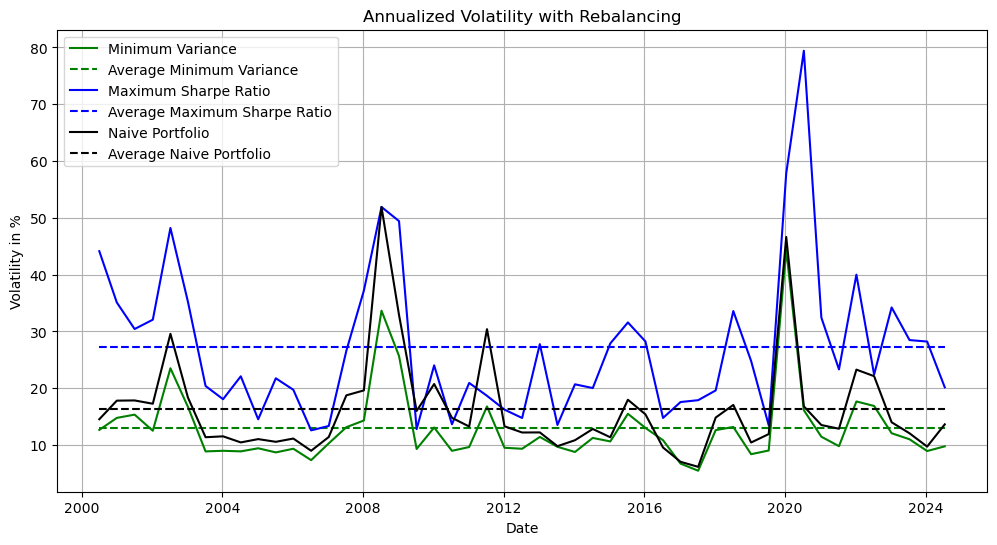

In [27]:
sharpe_ratio_dates: list[pd.Timestamp] = [date_list[i] for i in rebalancing_dates]

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()

ax.plot(sharpe_ratio_dates, minimum_variance_portfolio_volatility, color='g', label='Minimum Variance')
ax.plot(sharpe_ratio_dates, [np.mean(minimum_variance_portfolio_volatility) for _ in range(len(rebalancing_dates))], color='g', linestyle='--', label='Average Minimum Variance')

ax.plot(sharpe_ratio_dates, maximum_sharpe_ratio_portfolio_portfolio_volatility, color='b', label='Maximum Sharpe Ratio')
ax.plot(sharpe_ratio_dates, [np.mean(maximum_sharpe_ratio_portfolio_portfolio_volatility) for _ in range(len(rebalancing_dates))], color='b', linestyle='--', label='Average Maximum Sharpe Ratio')

ax.plot(sharpe_ratio_dates, naive_portfolio_portfolio_volatility, color='black', label='Naive Portfolio')
ax.plot(sharpe_ratio_dates, [np.mean(naive_portfolio_portfolio_volatility) for _ in range(len(rebalancing_dates))], color='black', linestyle='--', label='Average Naive Portfolio')

ax.set_xlabel('Date')
ax.set_ylabel('Volatility in %')
ax.set_title('Annualized Volatility with Rebalancing')
ax.legend(loc='upper left')
ax.grid()

In [28]:
df_corr = pd.DataFrame({'Minimum Variance': minimum_variance_portfolio_volatility, 'Maximum Sharpe Ratio': maximum_sharpe_ratio_portfolio_portfolio_volatility, 'Naive Portfolio': naive_portfolio_portfolio_volatility})
df_corr.corr()

Minimum Variance  Maximum Sharpe Ratio  Naive Portfolio
Minimum Variance              1.000000              0.701516         0.944884
Maximum Sharpe Ratio          0.701516              1.000000         0.613310
Naive Portfolio               0.944884              0.613310         1.000000

<h3>Function to calculate the Value at Risk</h3>

In [29]:
def calculate_rolling_VaR(portfolio_value: list[float], confidence_level: float = 0.05, window_size: int = 63) -> np.array:
    """
    Calculates the rolling Value at Risk (VaR) of a portfolio over a given window size.

    Parameters:
    portfolio_value (list[float]): A list containing the portfolio values at each time period.
    confidence_level (float): The confidence level for calculating the VaR (default is 0.05, i.e., 95% confidence level).
    window_size (int): The size of the rolling window for calculating the VaR (default is 63, i.e., 3 months).

    Returns:
    list[float]: A list containing the rolling VaR values at each time period.
    """
    price_series = pd.Series(portfolio_value)
    # Compute daily log returns
    returns = np.log(price_series / price_series.shift(1)).dropna()
    # Compute rolling VaR using historical percentiles
    rolling_var = returns.rolling(window=window_size).apply(
        lambda x: np.percentile(x, confidence_level * 100), raw=True
    )
    
    return rolling_var * 100

<h3>Plot the Value at Risk over time</h3>

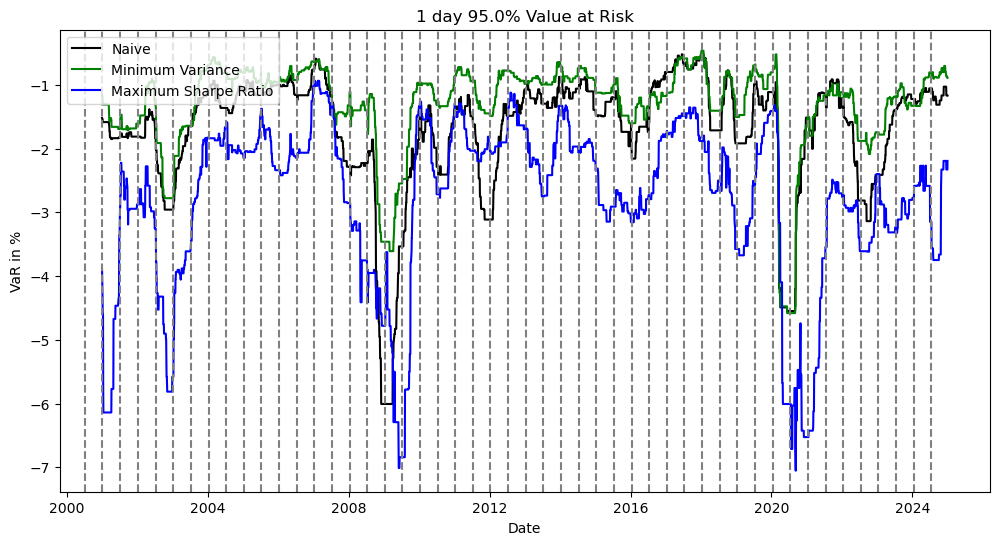

In [30]:
confidence_level: float = 0.05
days_used_to_determine_percentile: int = int(252/2)

naive_portfolio_VaR: list[float] = calculate_rolling_VaR(naive_portfolio_performance, confidence_level, window_size=days_used_to_determine_percentile)
minimum_variance_portfolio_VaR: list[float] = calculate_rolling_VaR(minimum_variance_portfolio_performance, confidence_level, window_size=days_used_to_determine_percentile)
maximum_sharpe_ratio_portfolio_VaR: list[float] = calculate_rolling_VaR(maximum_sharpe_ratio_portfolio_performance, confidence_level, window_size=days_used_to_determine_percentile)
# maximum_return_portfolio_VaR: list[float] = calculate_rolling_VaR(maximum_return_portfolio_performance, confidence_level, window_size=days_used_to_determine_percentile)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()
ax.set_title(f'1 day {100 - round(confidence_level * 100, 1)}% Value at Risk')
ax.set_ylabel('VaR in %')
ax.set_xlabel('Date')
ax.plot(data.index[days_used_to_determine_optimal_weights:], naive_portfolio_VaR, color='black', label='Naive')
ax.plot(data.index[days_used_to_determine_optimal_weights:], minimum_variance_portfolio_VaR, color='g', label='Minimum Variance')
ax.plot(data.index[days_used_to_determine_optimal_weights:], maximum_sharpe_ratio_portfolio_VaR, color='b', label='Maximum Sharpe Ratio')
# ax.plot(data.index[days_used_to_determine_optimal_weights:], maximum_return_portfolio_VaR, color='r', label='Maximum Return')
for rebalancing_date in rebalancing_dates:
    ax.axvline(date_list[rebalancing_date], color='gray', ls='--')
ax.legend(loc='upper left')

In [31]:
df_corr = pd.DataFrame({'Minimum Variance': minimum_variance_portfolio_VaR, 'Maximum Sharpe Ratio': maximum_sharpe_ratio_portfolio_VaR, 'Naive Portfolio': naive_portfolio_VaR})
df_corr.corr()

Minimum Variance  Maximum Sharpe Ratio  Naive Portfolio
Minimum Variance              1.000000              0.732034         0.886577
Maximum Sharpe Ratio          0.732034              1.000000         0.624772
Naive Portfolio               0.886577              0.624772         1.000000

<h3>Test the performance of different L1 regularization strengths</h3>

In [65]:
rebalancing_every_n_days: int = int(252/2)
days_used_to_determine_optimal_weights: int = int(0.5 * 252)
allow_short_positions: bool = True
days_per_year: int = 252

all_portfolios_performance_regularization_strengths: pd.DataFrame = pd.DataFrame()
all_portfolios_performance_regularization_strengths_volatility: pd.DataFrame = pd.DataFrame()
all_portfolios_performance_regularization_strengths_sharpe_ratio: pd.DataFrame = pd.DataFrame()
all_portfolios_performance_regularization_strengths_VaR: pd.DataFrame = pd.DataFrame()
all_portfolios_performance_regularization_strengths_weights: pd.DataFrame = pd.DataFrame()
all_portfolios_performance_regularization_strengths_sortino_ratio: pd.DataFrame = pd.DataFrame()
for portfolio_type in ['minimum_variance', 'maximum_sharpe_ratio']:
    if portfolio_type == 'minimum_variance':
        regularization_strengths: list[float] = [0, 0.001, 0.0025, 0.005, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 1]
    elif portfolio_type == 'maximum_sharpe_ratio':
        regularization_strengths: list[float] = [0, 0.05, 0.1, 0.25, 0.5, 1, 10, 20, 50, 100, 200]
        
# for portfolio_type in ['minimum_variance', 'maximum_sharpe_ratio', 'maximum_return']:
    for regularization_strength in regularization_strengths:
        performance: list[float] = []
        rebalancing_dates: list[int] = []
        
        performance, rebalancing_dates, sharpe_ratio, weights, portfolio_volatility, sortino_ratio, period_returns = track_portfolio_performance(portfolio_type, data, rebalance_freq=rebalancing_every_n_days, lookback_period=days_used_to_determine_optimal_weights,
                                                                regularization='l1', regularization_strength=regularization_strength, allow_short_positions=allow_short_positions,
                                                                days_per_year=days_per_year)
        all_portfolios_performance_regularization_strengths[f'{portfolio_type}_l1_{regularization_strength}'] = performance
        all_portfolios_performance_regularization_strengths_volatility[f'{portfolio_type}_l1_{regularization_strength}'] = portfolio_volatility
        all_portfolios_performance_regularization_strengths_sharpe_ratio[f'{portfolio_type}_l1_{regularization_strength}'] = sharpe_ratio
        all_portfolios_performance_regularization_strengths_VaR[f'{portfolio_type}_l1_{regularization_strength}'] = calculate_rolling_VaR(performance, confidence_level, window_size=days_used_to_determine_percentile)
        all_portfolios_performance_regularization_strengths_weights[f'{portfolio_type}_l1_{regularization_strength}'] = [np.std(weights[i]) * 100 for i in range(len(weights))] 
        all_portfolios_performance_regularization_strengths_sortino_ratio[f'{portfolio_type}_l1_{regularization_strength}'] = sortino_ratio 

-----------------MINIMUM VARIANCE-----------------
-----------------RETURN-----------------
[9.19432162 0.02314229]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.111
Method:                 Least Squares   F-statistic:                  0.002318
Date:                 Fr, 02 Mai 2025   Prob (F-statistic):              0.963
Time:                        15:54:07   Log-Likelihood:                -6.3484
No. Observations:                  11   AIC:                             16.70
Df Residuals:                       9   BIC:                             17.49
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------

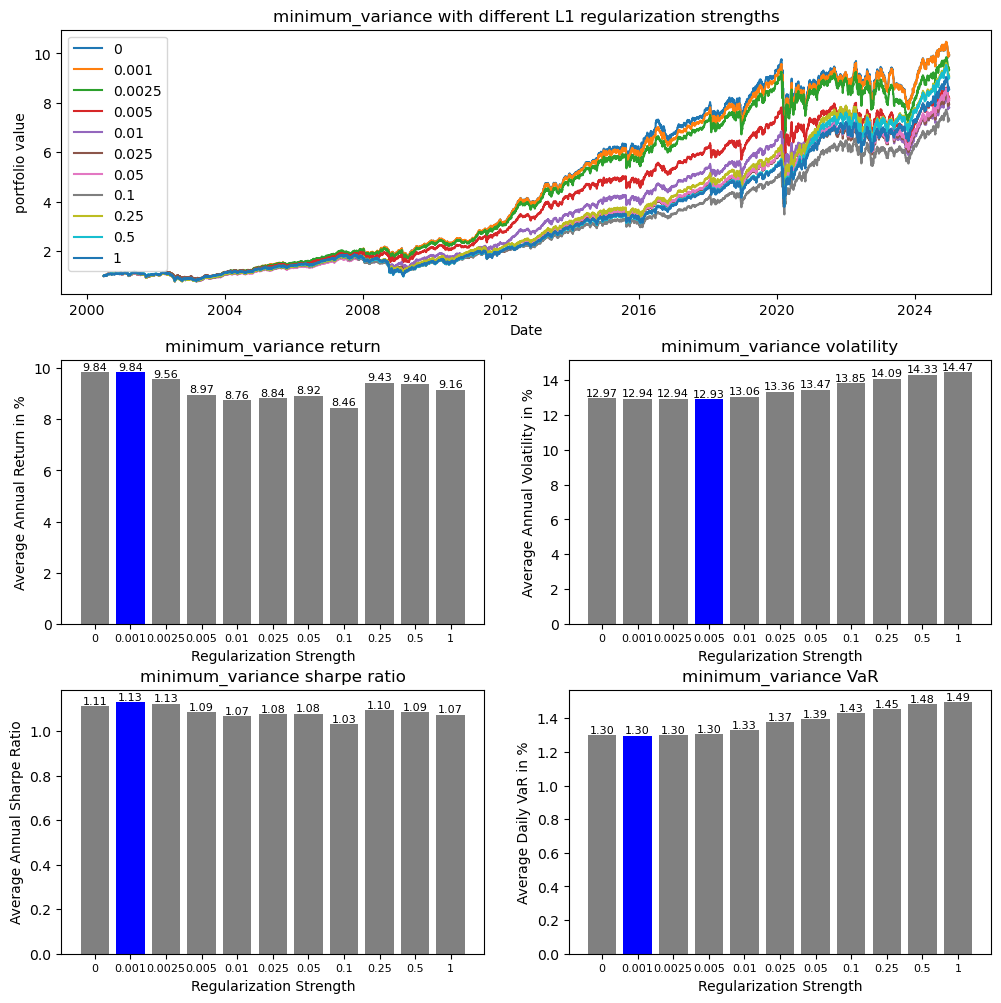

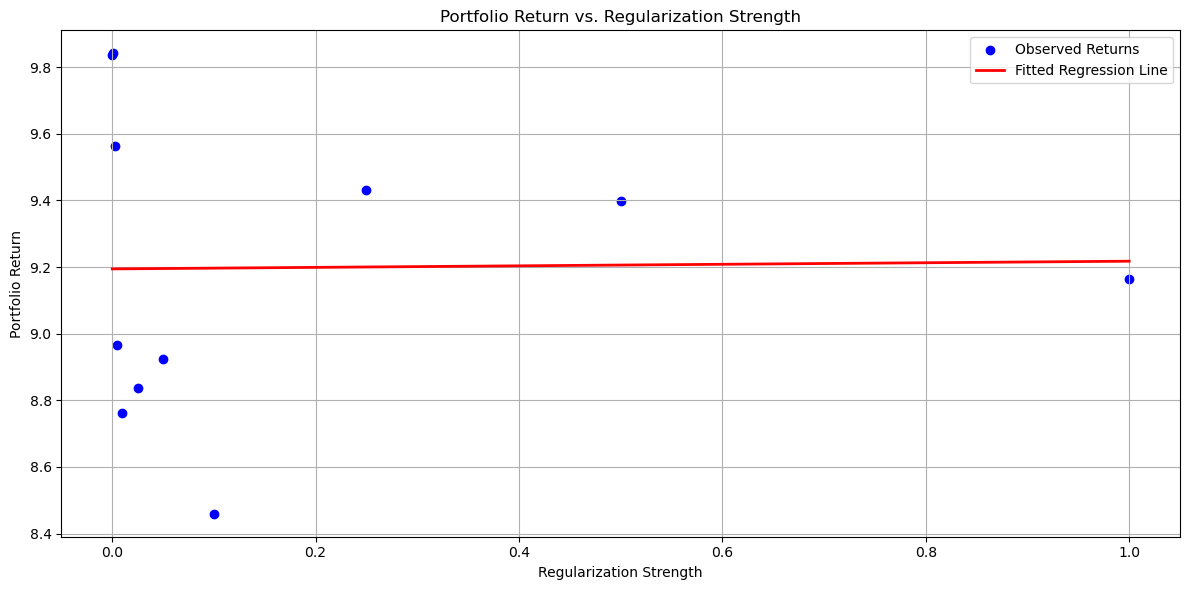

****************************************************************************************************
-----------------VOLATILITY-----------------
[13.20913829  1.59549365]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     21.59
Date:                 Fr, 02 Mai 2025   Prob (F-statistic):            0.00121
Time:                        15:54:07   Log-Likelihood:                -2.6482
No. Observations:                  11   AIC:                             9.296
Df Residuals:                       9   BIC:                             10.09
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err      

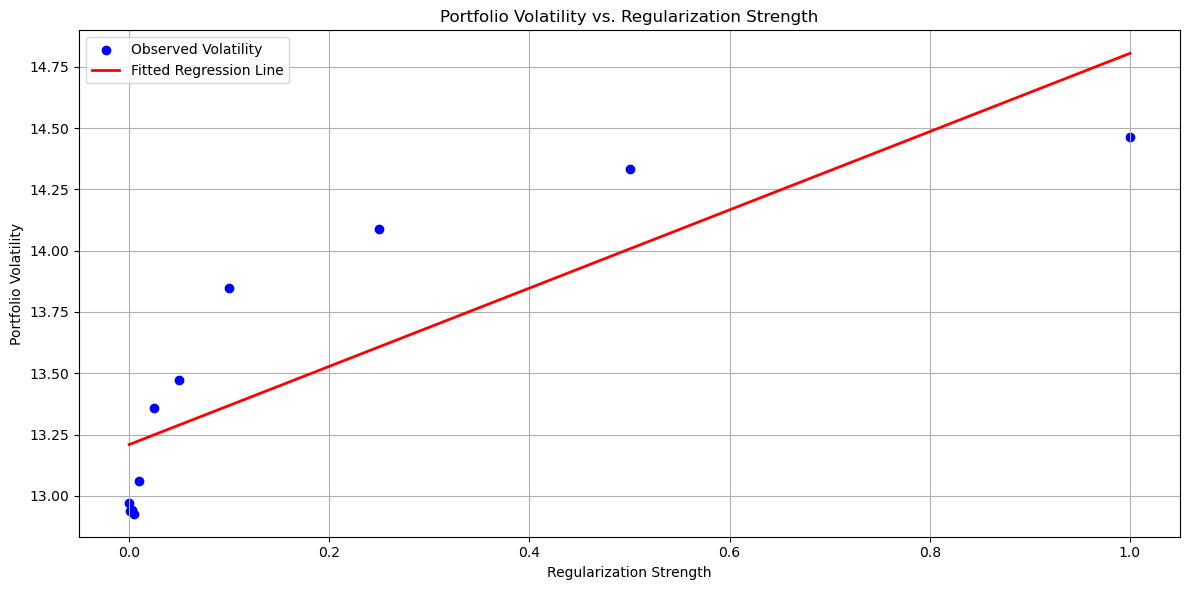

****************************************************************************************************
-----------------SHARPE RATIO-----------------
[ 1.09143508 -0.01949102]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                 -0.059
Method:                 Least Squares   F-statistic:                    0.4439
Date:                 Fr, 02 Mai 2025   Prob (F-statistic):              0.522
Time:                        15:54:08   Log-Likelihood:                 24.442
No. Observations:                  11   AIC:                            -44.88
Df Residuals:                       9   BIC:                            -44.09
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err    

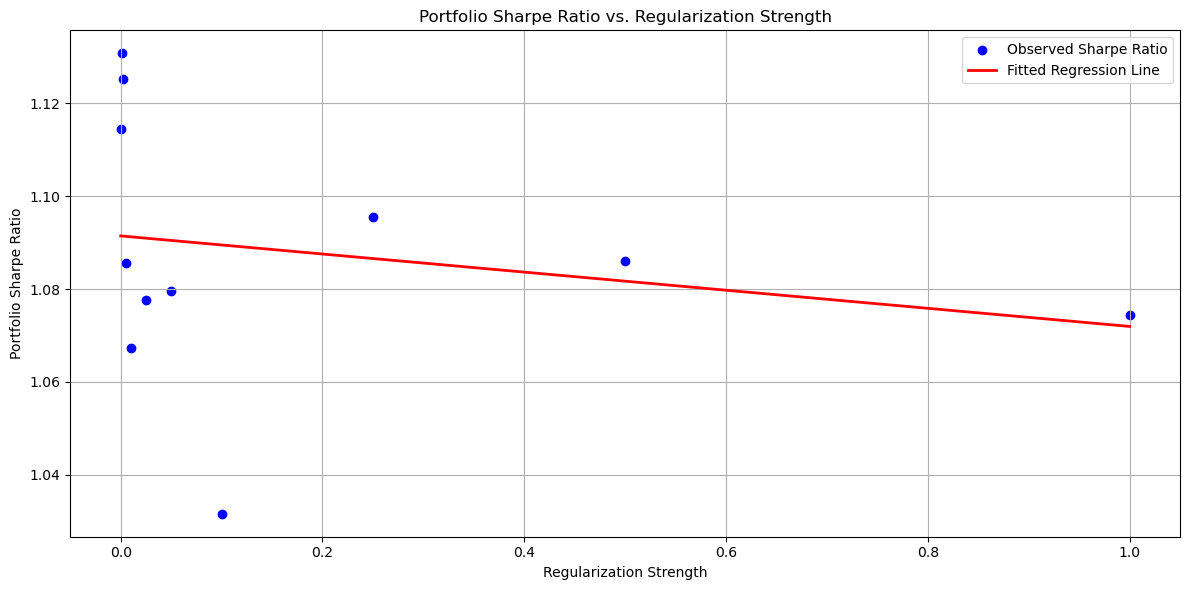

****************************************************************************************************
-----------------MAXIMUM SHARPE RATIO-----------------
-----------------RETURN-----------------
[ 1.21159883e+01 -5.03259345e-03]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     3.583
Date:                 Fr, 02 Mai 2025   Prob (F-statistic):             0.0909
Time:                        15:54:08   Log-Likelihood:                -7.5220
No. Observations:                  11   AIC:                             19.04
Df Residuals:                       9   BIC:                             19.84
Df Model:                           1                                         
Covariance Type:            nonrobust                     

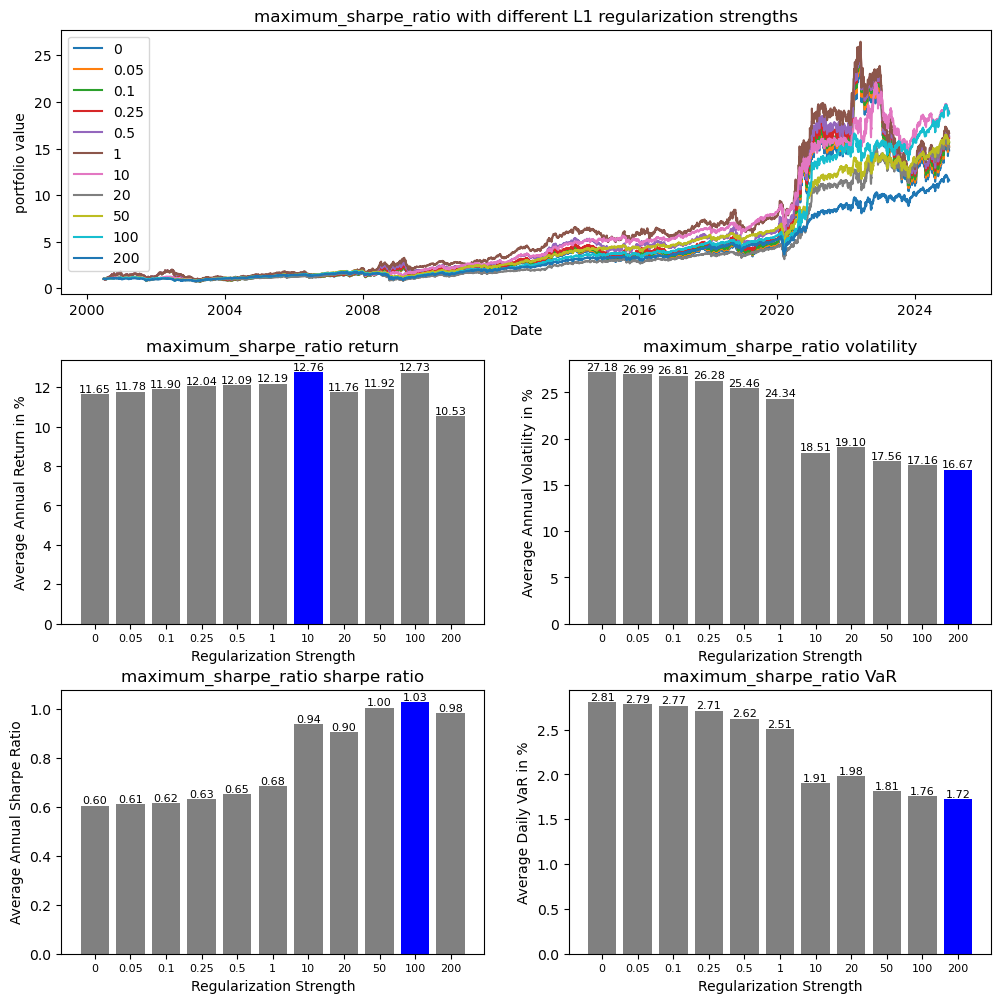

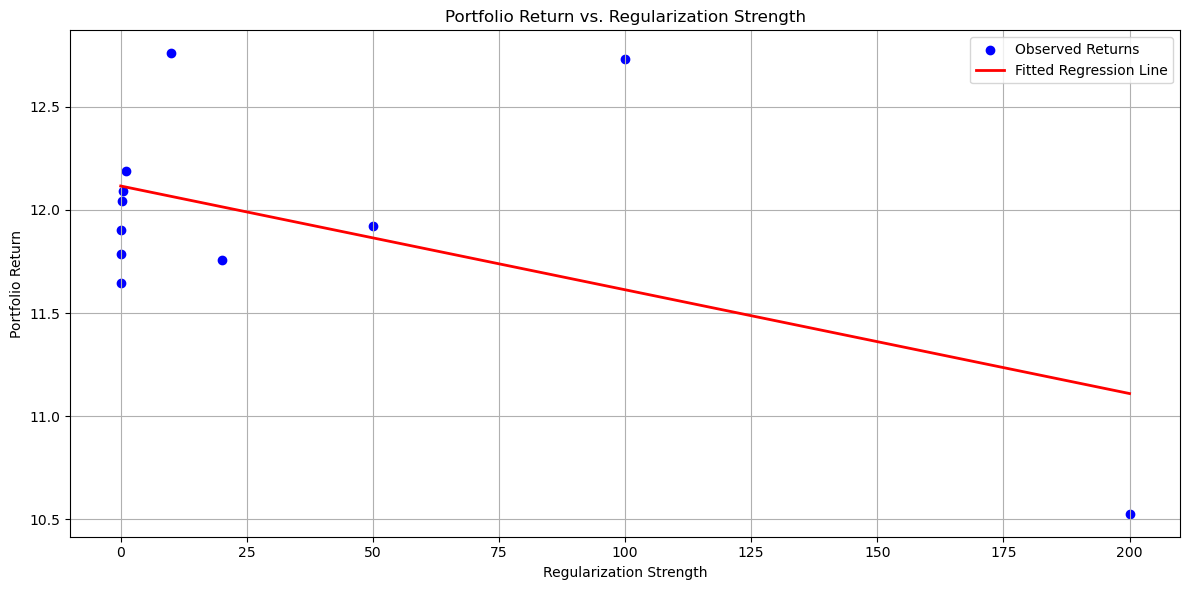

****************************************************************************************************
-----------------VOLATILITY-----------------
[24.11575462 -0.05031814]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     8.987
Date:                 Fr, 02 Mai 2025   Prob (F-statistic):             0.0150
Time:                        15:54:09   Log-Likelihood:                -27.790
No. Observations:                  11   AIC:                             59.58
Df Residuals:                       9   BIC:                             60.38
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err      

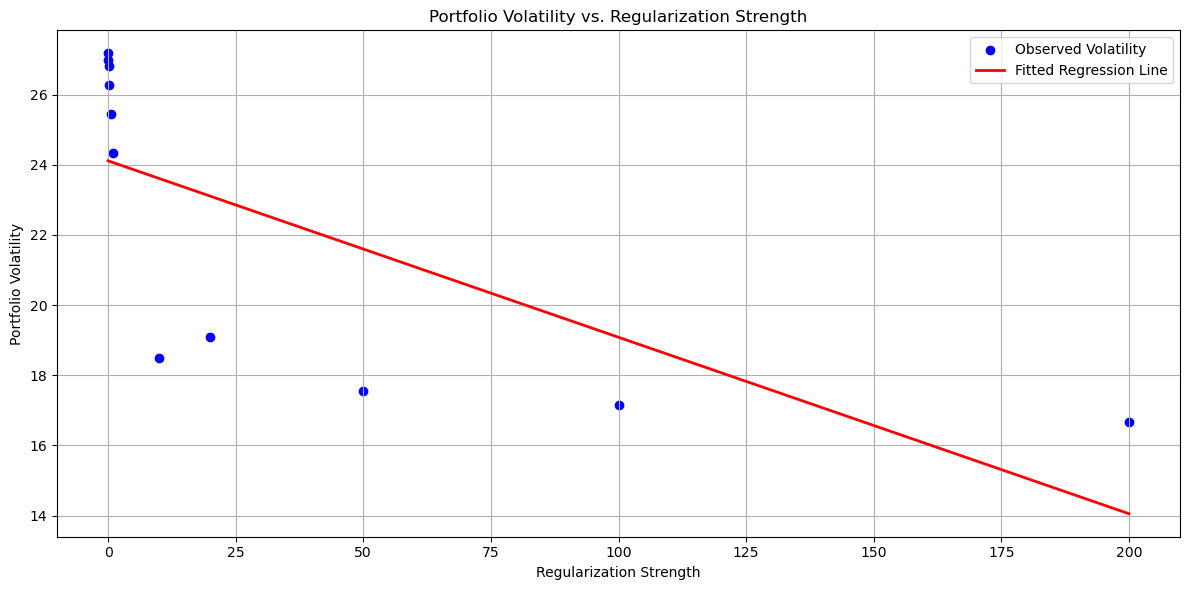

****************************************************************************************************
-----------------SHARPE RATIO-----------------
[0.71823612 0.00195413]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     7.827
Date:                 Fr, 02 Mai 2025   Prob (F-statistic):             0.0208
Time:                        15:54:09   Log-Likelihood:                 7.1821
No. Observations:                  11   AIC:                            -10.36
Df Residuals:                       9   BIC:                            -9.569
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err      

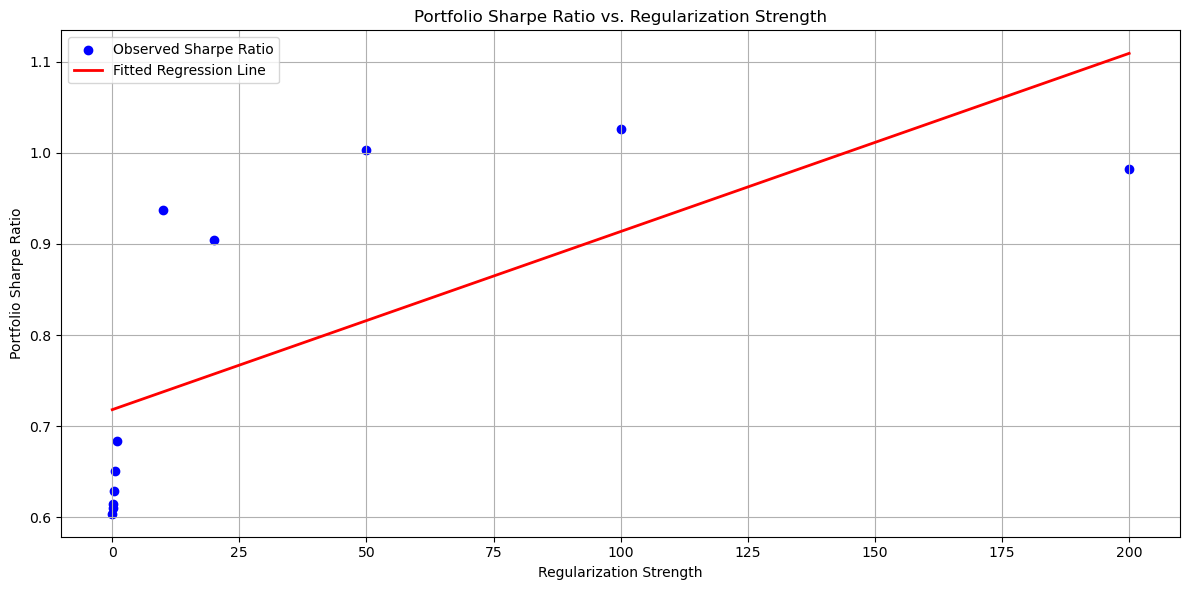

****************************************************************************************************


In [67]:
for i, portfolio_type in enumerate(['minimum_variance', 'maximum_sharpe_ratio']):
    portfolio_returns: list[float] = []
    portfolio_volatilities: list[float] = []
    portfolio_sharpe_ratios: list[float] = []
    portfolio_VaRs: list[float] = []
    labels: list[float] = []
    return_distributions = {}
    
    if portfolio_type == 'minimum_variance':
        regularization_strengths: list[float] = [0, 0.001, 0.0025, 0.005, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 1]
    elif portfolio_type == 'maximum_sharpe_ratio':
        regularization_strengths: list[float] = [0, 0.05, 0.1, 0.25, 0.5, 1, 10, 20, 50, 100, 200]
    
    # Compute mean returns, volatilities, sharpe ratio and VaR for each regularization strength
    for regularization_strength in regularization_strengths:
        returns = all_portfolios_performance_regularization_strengths[f'{portfolio_type}_l1_{regularization_strength}'].pct_change().dropna()
        return_distributions[f'{regularization_strength}'] = returns
        mean_return = returns.mean() * days_per_year * 100
        portfolio_returns.append(calc_cagr(all_portfolios_performance_regularization_strengths[f'{portfolio_type}_l1_{regularization_strength}'].to_list()) * 100)
        # portfolio_returns.append(mean_return)
        
        mean_volatility = all_portfolios_performance_regularization_strengths_volatility[f'{portfolio_type}_l1_{regularization_strength}'].mean()
        portfolio_volatilities.append(mean_volatility)
        
        sharpe_ratio = all_portfolios_performance_regularization_strengths_sharpe_ratio[f'{portfolio_type}_l1_{regularization_strength}'].mean()
        portfolio_sharpe_ratios.append(sharpe_ratio)
        
        # portfolio_VaR = calculate_rolling_VaR(all_portfolios_performance_regularization_strengths[f'{portfolio_type}_l1_{regularization_strength}'], confidence_level, window_size=days_used_to_determine_percentile).mean()
        portfolio_VaR = all_portfolios_performance_regularization_strengths_VaR[f'{portfolio_type}_l1_{regularization_strength}'].mean()
        portfolio_VaRs.append(portfolio_VaR * -1)
        
        labels.append(f'{regularization_strength}')
        
    # Determine the highest mean return
    max_index_return = np.argmax(portfolio_returns)
    max_label_return = labels[max_index_return]
    # Determine the lowest mean volatility
    min_index_volatility = np.argmin(portfolio_volatilities)
    min_label_volatility = labels[min_index_volatility]
    # Determine the highest mean Sharpe ratio
    max_index_sharpe_ratio = np.argmax(portfolio_sharpe_ratios)
    max_label_sharpe_ratio = labels[max_index_sharpe_ratio]
    # Determine the lowest mean VaR
    min_index_VaR = np.argmin(portfolio_VaRs)
    min_label_VaR = labels[min_index_VaR]
    
    fig = plt.figure(figsize=(12, 12))
    fig.subplots_adjust(hspace=0.25)
    gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])
    
    ax_perfromance = fig.add_subplot(gs[0, :])
    ax_perfromance.set_title(f'{portfolio_type} with different L1 regularization strengths')
    ax_perfromance.set_ylabel(f'portfolio value')
    for regularization_strength in regularization_strengths:
        ax_perfromance.plot(date_list[days_used_to_determine_optimal_weights:], all_portfolios_performance_regularization_strengths[f'{portfolio_type}_l1_{regularization_strength}'], label=f'{regularization_strength}')
    ax_perfromance.legend()
    ax_perfromance.set_xlabel('Date')
    
    ax_return = fig.add_subplot(gs[1, 0])
    ax_return.set_title(f'{portfolio_type} return')
    ax_return.set_xlabel('Regularization Strength')
    ax_return.set_ylabel('Average Annual Return in %')
    # Plot bars (blue for max, gray for others)
    for j, (label, value) in enumerate(zip(labels, portfolio_returns)):
        color = 'blue' if j == max_index_return else 'gray'
        ax_return.bar(label, value, color=color)
        ax_return.text(label, value, f'{value:.2f}', ha='center', va='bottom', fontsize=8)
    
    ax_volatility = fig.add_subplot(gs[1, 1])
    ax_volatility.set_title(f'{portfolio_type} volatility')
    ax_volatility.set_xlabel('Regularization Strength')
    ax_volatility.set_ylabel('Average Annual Volatility in %')
    # Plot bars (blue for min, gray for others)
    for j, (label, value) in enumerate(zip(labels, portfolio_volatilities)):
        color = 'blue' if j == min_index_volatility else 'gray'
        ax_volatility.bar(label, value, color=color)
        ax_volatility.text(label, value, f'{value:.2f}', ha='center', va='bottom', fontsize=8)
        
    ax_sharpe_ratio = fig.add_subplot(gs[2, 0])
    ax_sharpe_ratio.set_title(f'{portfolio_type} sharpe ratio')
    ax_sharpe_ratio.set_xlabel('Regularization Strength')
    ax_sharpe_ratio.set_ylabel('Average Annual Sharpe Ratio')
    # Plot bars (blue for max, gray for others)
    for j, (label, value) in enumerate(zip(labels, portfolio_sharpe_ratios)):
        color = 'blue' if j == max_index_sharpe_ratio else 'gray'
        ax_sharpe_ratio.bar(label, value, color=color)
        ax_sharpe_ratio.text(label, value, f'{value:.2f}', ha='center', va='bottom', fontsize=8)
        
    ax_VaR = fig.add_subplot(gs[2, 1])
    ax_VaR.set_title(f'{portfolio_type} VaR')
    ax_VaR.set_xlabel('Regularization Strength')
    ax_VaR.set_ylabel('Average Daily VaR in %')
    # Plot bars (blue for max, gray for others)
    for j, (label, value) in enumerate(zip(labels, portfolio_VaRs)):
        color = 'blue' if j == min_index_VaR else 'gray'
        ax_VaR.bar(label, value, color=color)
        ax_VaR.text(label, value, f'{value:.2f}', ha='center', va='bottom', fontsize=8)
        
    for ax in [ax_return, ax_volatility, ax_sharpe_ratio, ax_VaR]:
        ax.tick_params(axis='x', labelsize=8)
    
    if portfolio_type == 'minimum_variance':
        print('-----------------MINIMUM VARIANCE-----------------')
    else:
        print('-----------------MAXIMUM SHARPE RATIO-----------------')
    
    # epsilon: float = 1e-6
    # ols_regularization_strengths = np.log(np.array(regularization_strengths) + epsilon)
    # ols_regularization_strengths = sm.add_constant(ols_regularization_strengths)
    # --> adding a log term does not increase the R²
    
    ols_regularization_strengths = sm.add_constant(regularization_strengths)
    
    print('-----------------RETURN-----------------')
    model_return = sm.OLS(portfolio_returns, ols_regularization_strengths)
    result_return = model_return.fit()
    predicted_return: np.array = result_return.predict(ols_regularization_strengths)
    print(result_return.params)
    print(result_return.summary())
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot()
    plt.scatter(regularization_strengths, portfolio_returns, color='blue', label='Observed Returns')
    plt.plot(regularization_strengths, predicted_return, color='red', linewidth=2, label='Fitted Regression Line')
    plt.xlabel('Regularization Strength')
    plt.ylabel('Portfolio Return')
    plt.title('Portfolio Return vs. Regularization Strength')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print('*'*100)
    
    print('-----------------VOLATILITY-----------------')
    model_volatility = sm.OLS(portfolio_volatilities, ols_regularization_strengths)
    result_volatility = model_volatility.fit()
    predicted_volatility: np.array = result_volatility.predict(ols_regularization_strengths)
    print(result_volatility.params)
    print(result_volatility.summary())
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot()
    plt.scatter(regularization_strengths, portfolio_volatilities, color='blue', label='Observed Volatility')
    plt.plot(regularization_strengths, predicted_volatility, color='red', linewidth=2, label='Fitted Regression Line')
    plt.xlabel('Regularization Strength')
    plt.ylabel('Portfolio Volatility')
    plt.title('Portfolio Volatility vs. Regularization Strength')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print('*'*100)
    
    print('-----------------SHARPE RATIO-----------------')
    model_sharpe_ratio = sm.OLS(portfolio_sharpe_ratios, ols_regularization_strengths)
    result_sharpe_ratio = model_sharpe_ratio.fit()
    predicted_sharpe_ratio: np.array = result_sharpe_ratio.predict(ols_regularization_strengths)
    print(result_sharpe_ratio.params)
    print(result_sharpe_ratio.summary())  
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot()
    plt.scatter(regularization_strengths, portfolio_sharpe_ratios, color='blue', label='Observed Sharpe Ratio')
    plt.plot(regularization_strengths, predicted_sharpe_ratio, color='red', linewidth=2, label='Fitted Regression Line')
    plt.xlabel('Regularization Strength')
    plt.ylabel('Portfolio Sharpe Ratio')
    plt.title('Portfolio Sharpe Ratio vs. Regularization Strength')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print('*'*100)

            

-----------------WEIGHT STD minimum_variance-----------------
[ 7.55123746 -1.59363163]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     34.12
Date:                 Fr, 02 Mai 2025   Prob (F-statistic):           0.000246
Time:                        15:07:42   Log-Likelihood:                -27.676
No. Observations:                  11   AIC:                             59.35
Df Residuals:                       9   BIC:                             60.15
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

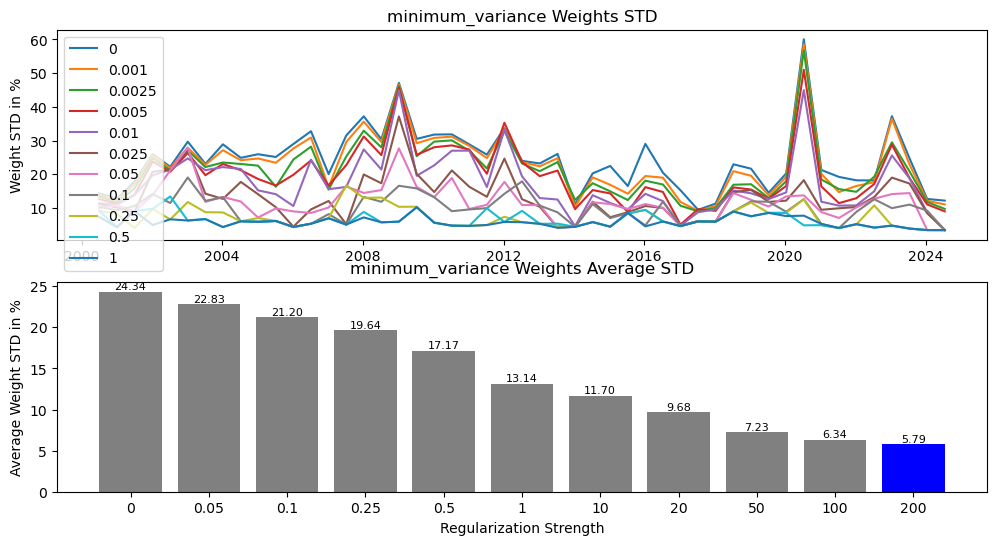

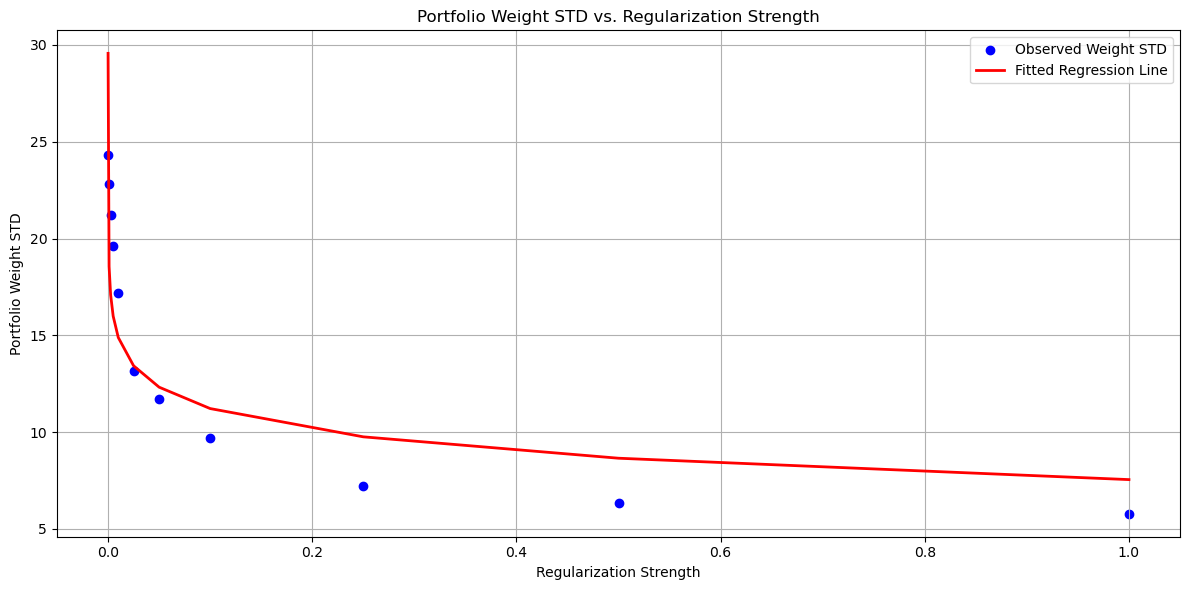

****************************************************************************************************
-----------------WEIGHT STD maximum_sharpe_ratio-----------------
[41.65182062 -3.4479472 ]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.552
Method:                 Least Squares   F-statistic:                     13.31
Date:                 Fr, 02 Mai 2025   Prob (F-statistic):            0.00533
Time:                        15:07:42   Log-Likelihood:                -44.991
No. Observations:                  11   AIC:                             93.98
Df Residuals:                       9   BIC:                             94.78
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 

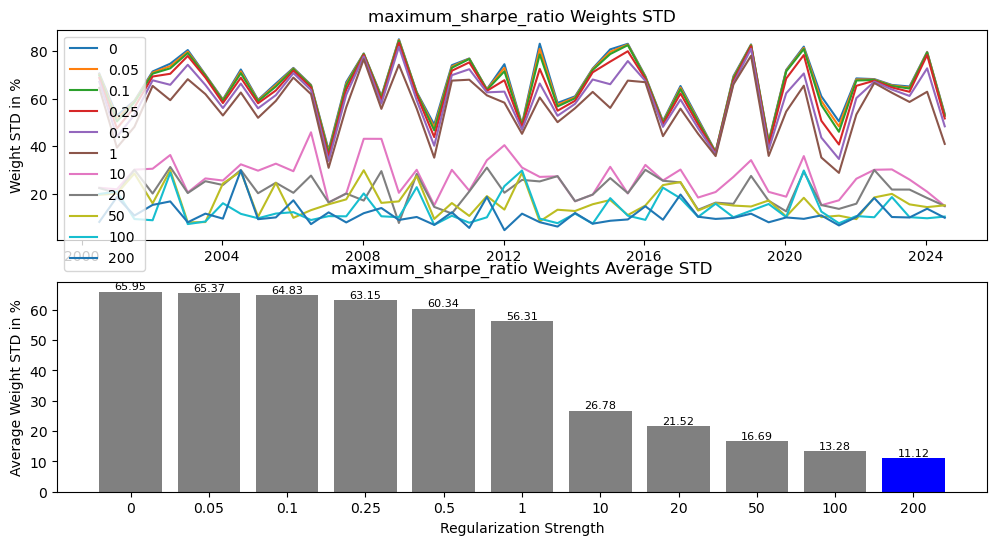

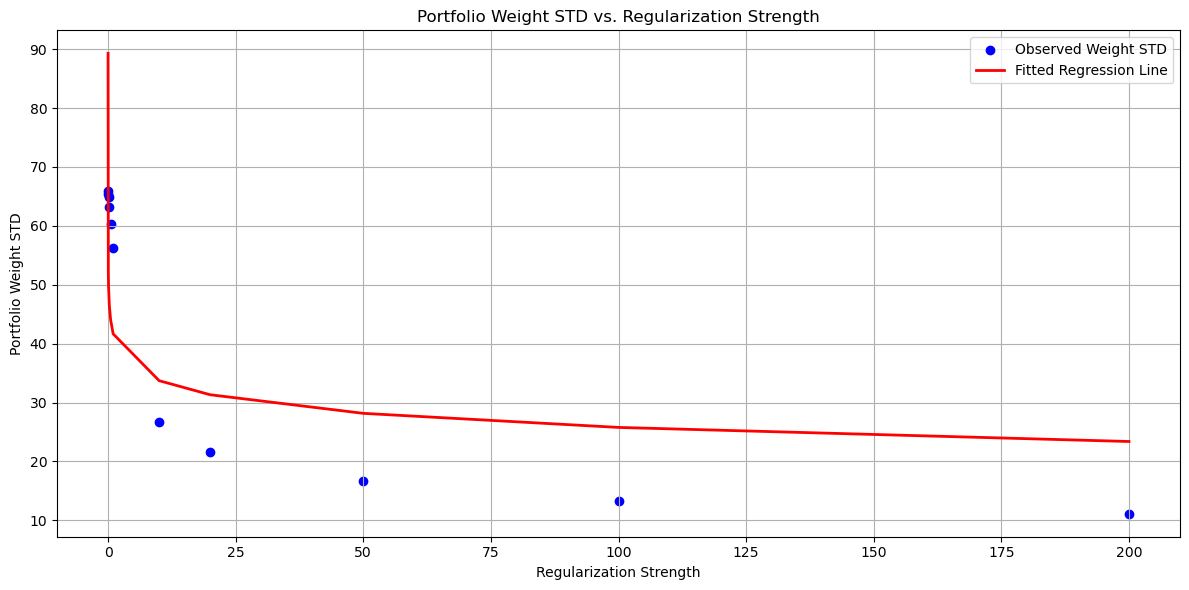

****************************************************************************************************


In [57]:
date_list: list[pd.Timestamp] = data.index.tolist()
min_date: pd.Timestamp = min(date_list)
previous_date: pd.Timestamp = min_date - pd.Timedelta(days=1)
date_list.insert(0, previous_date)

for i, portfolio_type in enumerate(['minimum_variance', 'maximum_sharpe_ratio']):
    if portfolio_type == 'minimum_variance':
        regularization_strengths: list[float] = [0, 0.001, 0.0025, 0.005, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 1]
    elif portfolio_type == 'maximum_sharpe_ratio':
        regularization_strengths: list[float] = [0, 0.05, 0.1, 0.25, 0.5, 1, 10, 20, 50, 100, 200]
        
    fig, axes = plt.subplots(2, 1, figsize=(12, 6))
    axes[0].set_title(f'{portfolio_type} Weights STD')
    for regularization_strength in regularization_strengths:
        axes[0].plot(data.index[rebalancing_dates], all_portfolios_performance_regularization_strengths_weights[f'{portfolio_type}_l1_{regularization_strength}'], label=f'{regularization_strength}')
    axes[0].legend(loc='upper left')
    # axes_0_xlabel = axes[0].set_xlabel('Date')
    # axes_0_xlabel.set_position((0.025, 0))
    axes[0].set_ylabel('Weight STD in %')
    
    # Determine the lowest mean weight STD

    portfolio_weights_std_average: list[float] = [all_portfolios_performance_regularization_strengths_weights[f'{portfolio_type}_l1_{regularization_strength}'].mean() for regularization_strength in regularization_strengths]
    min_index_weight_std = np.argmin(portfolio_weights_std_average)
    
    axes[1].set_title(f'{portfolio_type} Weights Average STD')
    axes[1].set_xlabel('Regularization Strength')
    axes[1].set_ylabel('Average Weight STD in %')
    # Plot bars (blue for max, gray for others)
    for j, (label, value) in enumerate(zip(labels, portfolio_weights_std_average)):
        color = 'blue' if j == min_index_weight_std else 'gray'
        axes[1].bar(label, value, color=color)
        axes[1].text(label, value, f'{value:.2f}', ha='center', va='bottom', fontsize=8)
    
    epsilon: float = 1e-6
    ols_regularization_strengths = np.log(np.array(regularization_strengths) + epsilon)
    ols_regularization_strengths = sm.add_constant(ols_regularization_strengths)
    # --> adding a log term does not increase the R²
    # ols_regularization_strengths = sm.add_constant(regularization_strengths)
    
    model_weights = sm.OLS(portfolio_weights_std_average, ols_regularization_strengths)
    result_weight_std = model_weights.fit()
    predicted_portfolio_weights_std_average: np.array = result_weight_std.predict(ols_regularization_strengths)
    
    print(f'-----------------WEIGHT STD {portfolio_type}-----------------')
    print(result_weight_std.params)
    print(result_weight_std.summary())
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot()
    plt.scatter(regularization_strengths, portfolio_weights_std_average, color='blue', label='Observed Weight STD')
    plt.plot(regularization_strengths, predicted_portfolio_weights_std_average, color='red', linewidth=2, label='Fitted Regression Line')
    plt.xlabel('Regularization Strength')
    plt.ylabel('Portfolio Weight STD')
    plt.title('Portfolio Weight STD vs. Regularization Strength')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print('*'*100)
    
        

In [51]:
predicted_portfolio_weights_std_average

array([51.87709531, 51.86330789, 51.84952047, 51.80815819, 51.73922107,
       51.60134683, 49.1196105 , 46.36212568, 38.08967123, 24.30224714,
       -3.27260103])

<h3>L2 Regularization</h3>

In [68]:
rebalancing_every_n_days: int = int(252/2)
days_used_to_determine_optimal_weights: int = int(0.5 * 252)
allow_short_positions: bool = True
days_per_year: int = 252

all_portfolios_performance_regularization_strengths: pd.DataFrame = pd.DataFrame()
all_portfolios_performance_regularization_strengths_volatility: pd.DataFrame = pd.DataFrame()
all_portfolios_performance_regularization_strengths_sharpe_ratio: pd.DataFrame = pd.DataFrame()
all_portfolios_performance_regularization_strengths_VaR: pd.DataFrame = pd.DataFrame()
all_portfolios_performance_regularization_strengths_weights: pd.DataFrame = pd.DataFrame()
all_portfolios_performance_regularization_strengths_sortino_ratio: pd.DataFrame = pd.DataFrame()
for portfolio_type in ['minimum_variance', 'maximum_sharpe_ratio']:
    if portfolio_type == 'minimum_variance':
        regularization_strengths: list[float] = [0, 0.001, 0.0025, 0.005, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 1]
    elif portfolio_type == 'maximum_sharpe_ratio':
        regularization_strengths: list[float] = [0, 0.05, 0.1, 0.25, 0.5, 1, 10, 20, 50, 100, 200]
        
# for portfolio_type in ['minimum_variance', 'maximum_sharpe_ratio', 'maximum_return']:
    for regularization_strength in regularization_strengths:
        performance: list[float] = []
        rebalancing_dates: list[int] = []
        
        performance, rebalancing_dates, sharpe_ratio, weights, portfolio_volatility, sortino_ratio, period_returns = track_portfolio_performance(portfolio_type, data, rebalance_freq=rebalancing_every_n_days, lookback_period=days_used_to_determine_optimal_weights,
                                                                regularization='l2', regularization_strength=regularization_strength, allow_short_positions=allow_short_positions,
                                                                days_per_year=days_per_year)
        all_portfolios_performance_regularization_strengths[f'{portfolio_type}_l2_{regularization_strength}'] = performance
        all_portfolios_performance_regularization_strengths_volatility[f'{portfolio_type}_l2_{regularization_strength}'] = portfolio_volatility
        all_portfolios_performance_regularization_strengths_sharpe_ratio[f'{portfolio_type}_l2_{regularization_strength}'] = sharpe_ratio
        all_portfolios_performance_regularization_strengths_VaR[f'{portfolio_type}_l2_{regularization_strength}'] = calculate_rolling_VaR(performance, confidence_level, window_size=days_used_to_determine_percentile)
        all_portfolios_performance_regularization_strengths_weights[f'{portfolio_type}_l2_{regularization_strength}'] = [np.std(weights[i]) * 100 for i in range(len(weights))] 
        all_portfolios_performance_regularization_strengths_sortino_ratio[f'{portfolio_type}_l2_{regularization_strength}'] = sortino_ratio 

-----------------MINIMUM VARIANCE-----------------
-----------------RETURN-----------------
[ 9.1569915  -0.20548691]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                 -0.091
Method:                 Least Squares   F-statistic:                    0.1663
Date:                 Fr, 02 Mai 2025   Prob (F-statistic):              0.693
Time:                        16:11:22   Log-Likelihood:                -6.8659
No. Observations:                  11   AIC:                             17.73
Df Residuals:                       9   BIC:                             18.53
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------

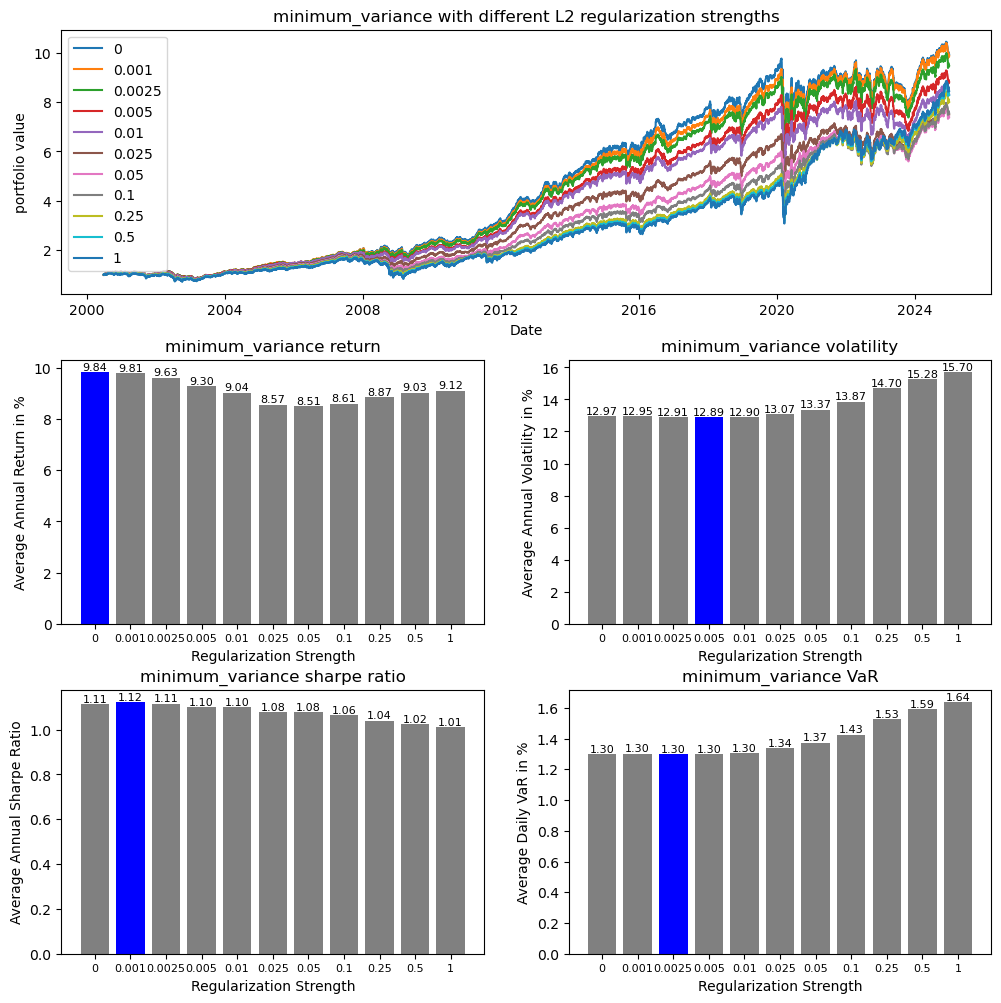

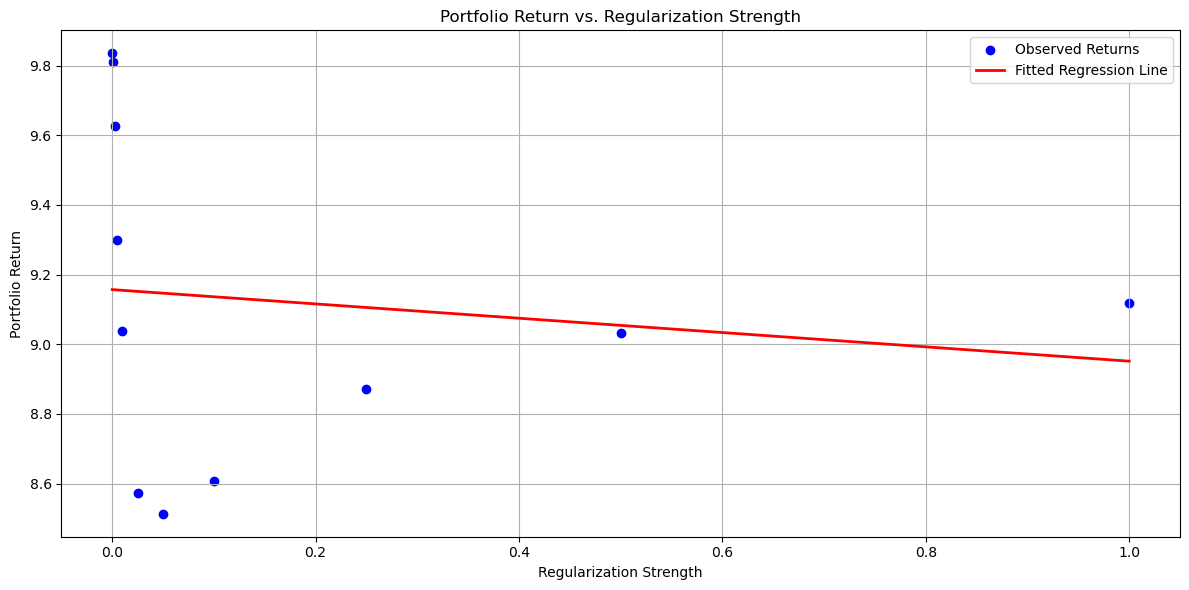

****************************************************************************************************
-----------------VOLATILITY-----------------
[13.14574212  3.07678619]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     48.69
Date:                 Fr, 02 Mai 2025   Prob (F-statistic):           6.48e-05
Time:                        16:11:22   Log-Likelihood:                -5.3993
No. Observations:                  11   AIC:                             14.80
Df Residuals:                       9   BIC:                             15.59
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err      

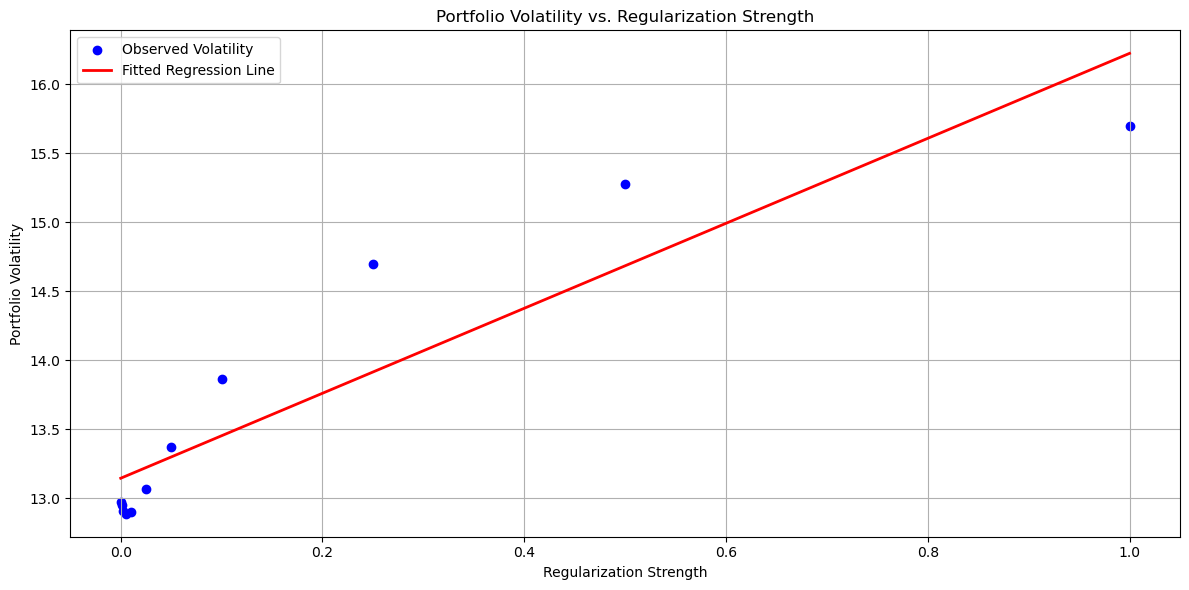

****************************************************************************************************
-----------------SHARPE RATIO-----------------
[ 1.09537098 -0.10490316]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     24.49
Date:                 Fr, 02 Mai 2025   Prob (F-statistic):           0.000792
Time:                        16:11:23   Log-Likelihood:                 27.986
No. Observations:                  11   AIC:                            -51.97
Df Residuals:                       9   BIC:                            -51.18
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err    

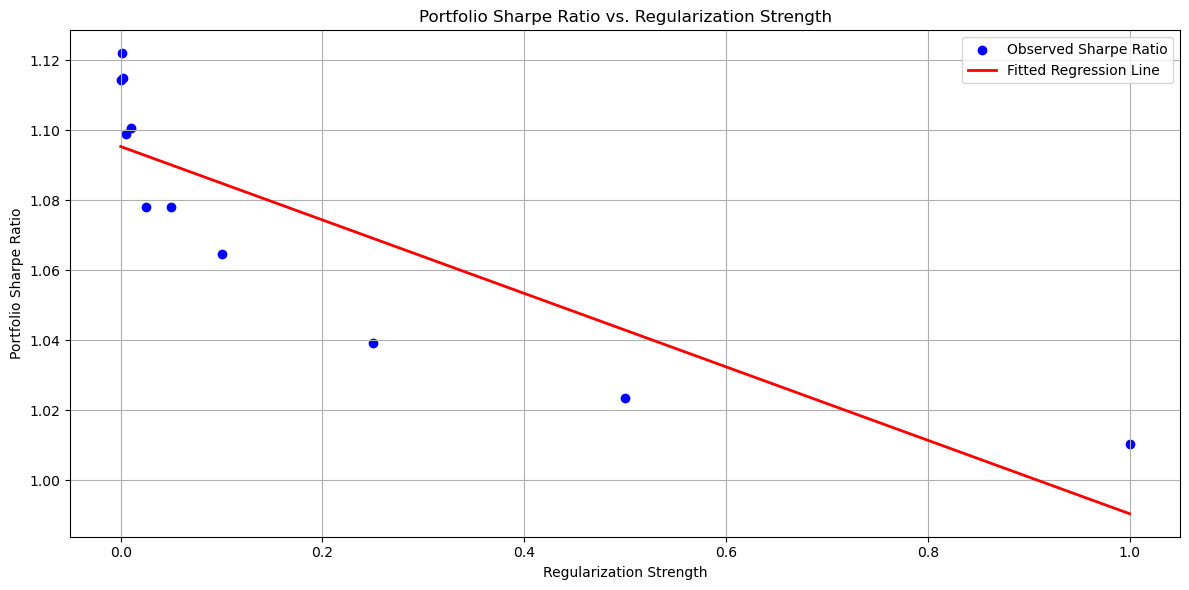

****************************************************************************************************
-----------------MAXIMUM SHARPE RATIO-----------------
-----------------RETURN-----------------
[11.69084561 -0.01910155]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     22.37
Date:                 Fr, 02 Mai 2025   Prob (F-statistic):            0.00107
Time:                        16:11:23   Log-Likelihood:                -12.120
No. Observations:                  11   AIC:                             28.24
Df Residuals:                       9   BIC:                             29.04
Df Model:                           1                                         
Covariance Type:            nonrobust                             

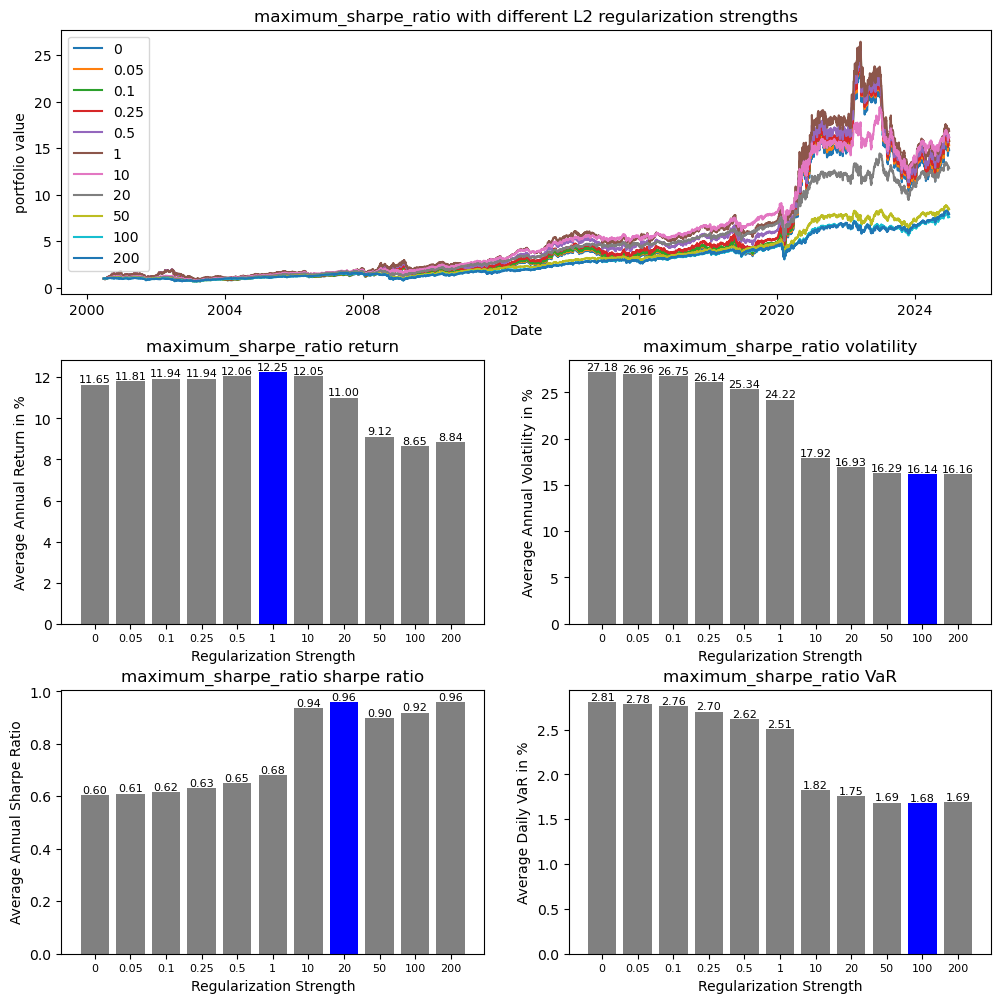

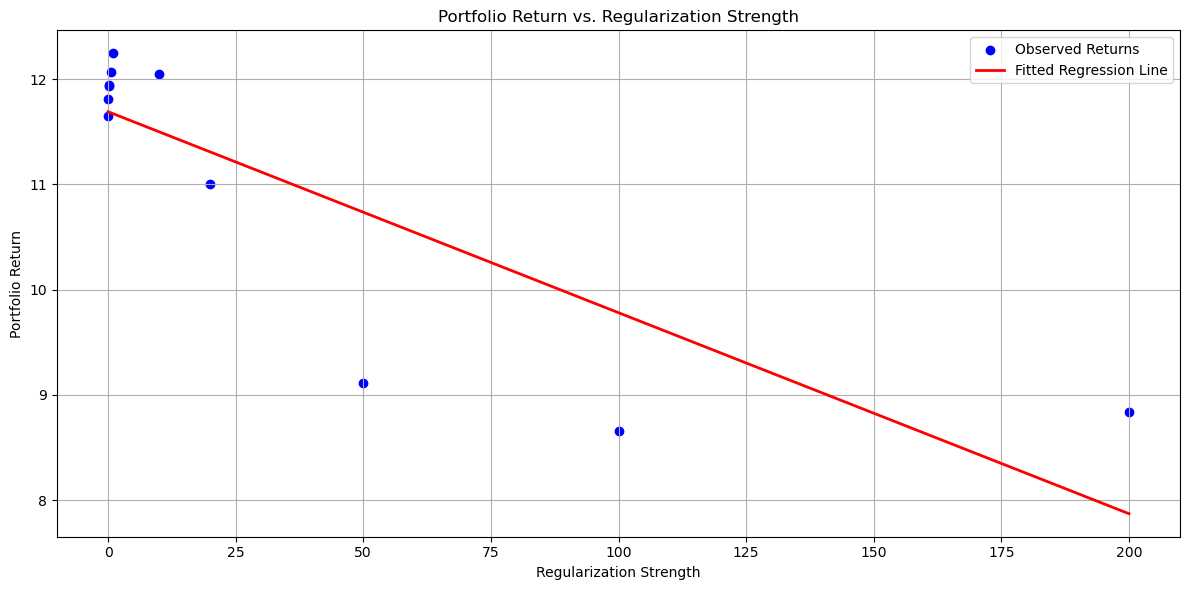

****************************************************************************************************
-----------------VOLATILITY-----------------
[23.66182724 -0.05302379]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     7.261
Date:                 Fr, 02 Mai 2025   Prob (F-statistic):             0.0246
Time:                        16:11:24   Log-Likelihood:                -29.539
No. Observations:                  11   AIC:                             63.08
Df Residuals:                       9   BIC:                             63.87
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err      

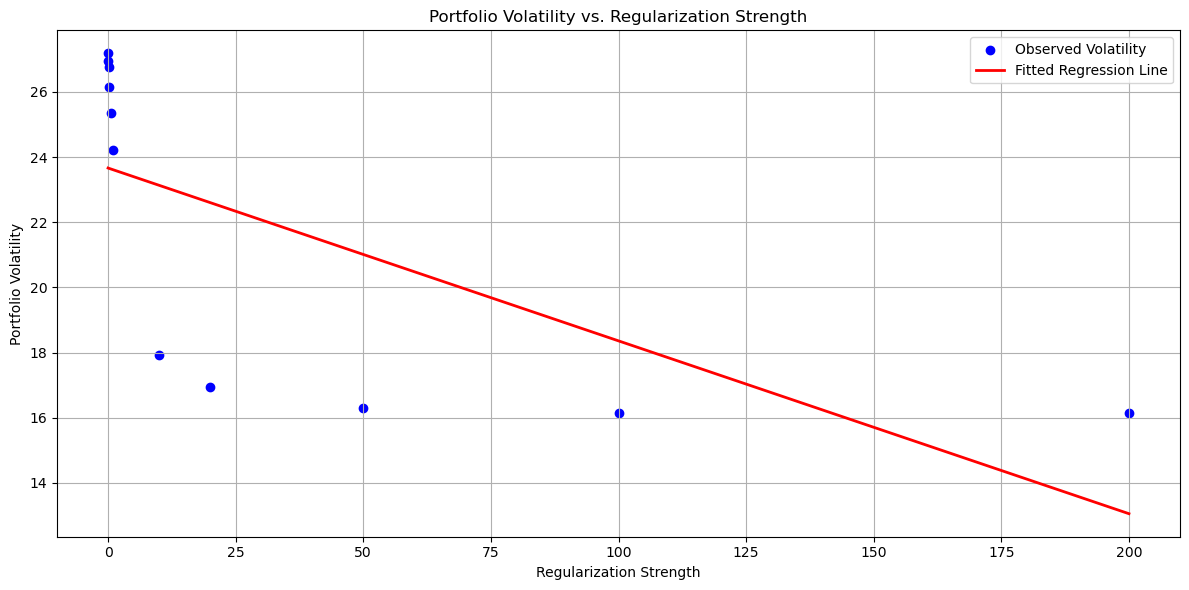

****************************************************************************************************
-----------------SHARPE RATIO-----------------
[0.71323373 0.00162021]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     6.198
Date:                 Fr, 02 Mai 2025   Prob (F-statistic):             0.0344
Time:                        16:11:24   Log-Likelihood:                 7.9602
No. Observations:                  11   AIC:                            -11.92
Df Residuals:                       9   BIC:                            -11.12
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err      

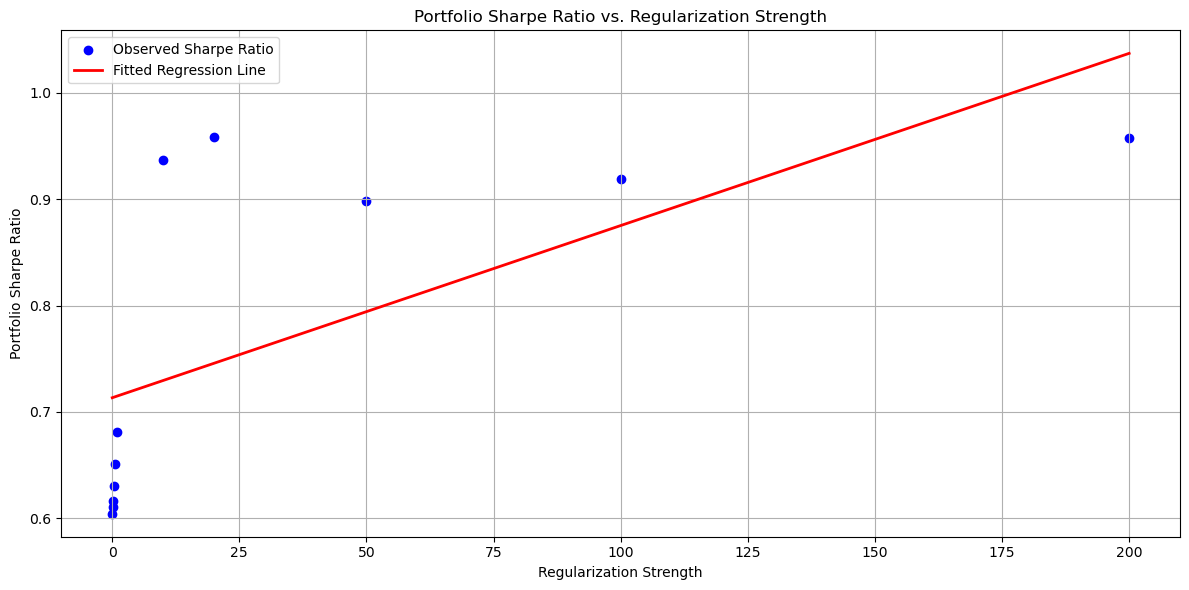

****************************************************************************************************


In [70]:
for i, portfolio_type in enumerate(['minimum_variance', 'maximum_sharpe_ratio']):
    portfolio_returns: list[float] = []
    portfolio_volatilities: list[float] = []
    portfolio_sharpe_ratios: list[float] = []
    portfolio_VaRs: list[float] = []
    labels: list[float] = []
    return_distributions = {}
    
    if portfolio_type == 'minimum_variance':
        regularization_strengths: list[float] = [0, 0.001, 0.0025, 0.005, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 1]
    elif portfolio_type == 'maximum_sharpe_ratio':
        regularization_strengths: list[float] = [0, 0.05, 0.1, 0.25, 0.5, 1, 10, 20, 50, 100, 200]
    
    # Compute mean returns, volatilities, sharpe ratio and VaR for each regularization strength
    for regularization_strength in regularization_strengths:
        returns = all_portfolios_performance_regularization_strengths[f'{portfolio_type}_l2_{regularization_strength}'].pct_change().dropna()
        return_distributions[f'{regularization_strength}'] = returns
        mean_return = returns.mean() * days_per_year * 100
        portfolio_returns.append(calc_cagr(all_portfolios_performance_regularization_strengths[f'{portfolio_type}_l2_{regularization_strength}'].to_list()) * 100)
        # portfolio_returns.append(mean_return)
        
        mean_volatility = all_portfolios_performance_regularization_strengths_volatility[f'{portfolio_type}_l2_{regularization_strength}'].mean()
        portfolio_volatilities.append(mean_volatility)
        
        sharpe_ratio = all_portfolios_performance_regularization_strengths_sharpe_ratio[f'{portfolio_type}_l2_{regularization_strength}'].mean()
        portfolio_sharpe_ratios.append(sharpe_ratio)
        
        # portfolio_VaR = calculate_rolling_VaR(all_portfolios_performance_regularization_strengths[f'{portfolio_type}_l2_{regularization_strength}'], confidence_level, window_size=days_used_to_determine_percentile).mean()
        portfolio_VaR = all_portfolios_performance_regularization_strengths_VaR[f'{portfolio_type}_l2_{regularization_strength}'].mean()
        portfolio_VaRs.append(portfolio_VaR * -1)
        
        labels.append(f'{regularization_strength}')
        
    # Determine the highest mean return
    max_index_return = np.argmax(portfolio_returns)
    max_label_return = labels[max_index_return]
    # Determine the lowest mean volatility
    min_index_volatility = np.argmin(portfolio_volatilities)
    min_label_volatility = labels[min_index_volatility]
    # Determine the highest mean Sharpe ratio
    max_index_sharpe_ratio = np.argmax(portfolio_sharpe_ratios)
    max_label_sharpe_ratio = labels[max_index_sharpe_ratio]
    # Determine the lowest mean VaR
    min_index_VaR = np.argmin(portfolio_VaRs)
    min_label_VaR = labels[min_index_VaR]
    
    fig = plt.figure(figsize=(12, 12))
    fig.subplots_adjust(hspace=0.25)
    gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])
    
    ax_perfromance = fig.add_subplot(gs[0, :])
    ax_perfromance.set_title(f'{portfolio_type} with different L2 regularization strengths')
    ax_perfromance.set_ylabel(f'portfolio value')
    for regularization_strength in regularization_strengths:
        ax_perfromance.plot(date_list[days_used_to_determine_optimal_weights:], all_portfolios_performance_regularization_strengths[f'{portfolio_type}_l2_{regularization_strength}'], label=f'{regularization_strength}')
    ax_perfromance.legend()
    ax_perfromance.set_xlabel('Date')
    
    ax_return = fig.add_subplot(gs[1, 0])
    ax_return.set_title(f'{portfolio_type} return')
    ax_return.set_xlabel('Regularization Strength')
    ax_return.set_ylabel('Average Annual Return in %')
    # Plot bars (blue for max, gray for others)
    for j, (label, value) in enumerate(zip(labels, portfolio_returns)):
        color = 'blue' if j == max_index_return else 'gray'
        ax_return.bar(label, value, color=color)
        ax_return.text(label, value, f'{value:.2f}', ha='center', va='bottom', fontsize=8)
    
    ax_volatility = fig.add_subplot(gs[1, 1])
    ax_volatility.set_title(f'{portfolio_type} volatility')
    ax_volatility.set_xlabel('Regularization Strength')
    ax_volatility.set_ylabel('Average Annual Volatility in %')
    # Plot bars (blue for min, gray for others)
    for j, (label, value) in enumerate(zip(labels, portfolio_volatilities)):
        color = 'blue' if j == min_index_volatility else 'gray'
        ax_volatility.bar(label, value, color=color)
        ax_volatility.text(label, value, f'{value:.2f}', ha='center', va='bottom', fontsize=8)
        
    ax_sharpe_ratio = fig.add_subplot(gs[2, 0])
    ax_sharpe_ratio.set_title(f'{portfolio_type} sharpe ratio')
    ax_sharpe_ratio.set_xlabel('Regularization Strength')
    ax_sharpe_ratio.set_ylabel('Average Annual Sharpe Ratio')
    # Plot bars (blue for max, gray for others)
    for j, (label, value) in enumerate(zip(labels, portfolio_sharpe_ratios)):
        color = 'blue' if j == max_index_sharpe_ratio else 'gray'
        ax_sharpe_ratio.bar(label, value, color=color)
        ax_sharpe_ratio.text(label, value, f'{value:.2f}', ha='center', va='bottom', fontsize=8)
        
    ax_VaR = fig.add_subplot(gs[2, 1])
    ax_VaR.set_title(f'{portfolio_type} VaR')
    ax_VaR.set_xlabel('Regularization Strength')
    ax_VaR.set_ylabel('Average Daily VaR in %')
    # Plot bars (blue for max, gray for others)
    for j, (label, value) in enumerate(zip(labels, portfolio_VaRs)):
        color = 'blue' if j == min_index_VaR else 'gray'
        ax_VaR.bar(label, value, color=color)
        ax_VaR.text(label, value, f'{value:.2f}', ha='center', va='bottom', fontsize=8)
        
    for ax in [ax_return, ax_volatility, ax_sharpe_ratio, ax_VaR]:
        ax.tick_params(axis='x', labelsize=8)
    
    if portfolio_type == 'minimum_variance':
        print('-----------------MINIMUM VARIANCE-----------------')
    else:
        print('-----------------MAXIMUM SHARPE RATIO-----------------')
        
    # epsilon: float = 1e-6
    # ols_regularization_strengths = np.log(np.array(regularization_strengths) + epsilon)
    # ols_regularization_strengths = sm.add_constant(ols_regularization_strengths + epsilon)
    # --> adding a log term does not increase the R²
    ols_regularization_strengths = sm.add_constant(regularization_strengths)
    
    print('-----------------RETURN-----------------')
    model_return = sm.OLS(portfolio_returns, ols_regularization_strengths)
    result_return = model_return.fit()
    predicted_return: np.array = result_return.predict(ols_regularization_strengths)
    print(result_return.params)
    print(result_return.summary())
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot()
    plt.scatter(regularization_strengths, portfolio_returns, color='blue', label='Observed Returns')
    plt.plot(regularization_strengths, predicted_return, color='red', linewidth=2, label='Fitted Regression Line')
    plt.xlabel('Regularization Strength')
    plt.ylabel('Portfolio Return')
    plt.title('Portfolio Return vs. Regularization Strength')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print('*'*100)
    
    print('-----------------VOLATILITY-----------------')
    model_volatility = sm.OLS(portfolio_volatilities, ols_regularization_strengths)
    result_volatility = model_volatility.fit()
    predicted_volatility: np.array = result_volatility.predict(ols_regularization_strengths)
    print(result_volatility.params)
    print(result_volatility.summary())
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot()
    plt.scatter(regularization_strengths, portfolio_volatilities, color='blue', label='Observed Volatility')
    plt.plot(regularization_strengths, predicted_volatility, color='red', linewidth=2, label='Fitted Regression Line')
    plt.xlabel('Regularization Strength')
    plt.ylabel('Portfolio Volatility')
    plt.title('Portfolio Volatility vs. Regularization Strength')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print('*'*100)
    
    print('-----------------SHARPE RATIO-----------------')
    model_sharpe_ratio = sm.OLS(portfolio_sharpe_ratios, ols_regularization_strengths)
    result_sharpe_ratio = model_sharpe_ratio.fit()
    predicted_sharpe_ratio: np.array = result_sharpe_ratio.predict(ols_regularization_strengths)
    print(result_sharpe_ratio.params)
    print(result_sharpe_ratio.summary())  
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot()
    plt.scatter(regularization_strengths, portfolio_sharpe_ratios, color='blue', label='Observed Sharpe Ratio')
    plt.plot(regularization_strengths, predicted_sharpe_ratio, color='red', linewidth=2, label='Fitted Regression Line')
    plt.xlabel('Regularization Strength')
    plt.ylabel('Portfolio Sharpe Ratio')
    plt.title('Portfolio Sharpe Ratio vs. Regularization Strength')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print('*'*100)  
    

-----------------WEIGHT STD minimum_variance-----------------
[ 5.19154215 -1.9309316 ]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     24.76
Date:                 Fr, 02 Mai 2025   Prob (F-statistic):           0.000764
Time:                        15:14:15   Log-Likelihood:                -31.552
No. Observations:                  11   AIC:                             67.10
Df Residuals:                       9   BIC:                             67.90
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

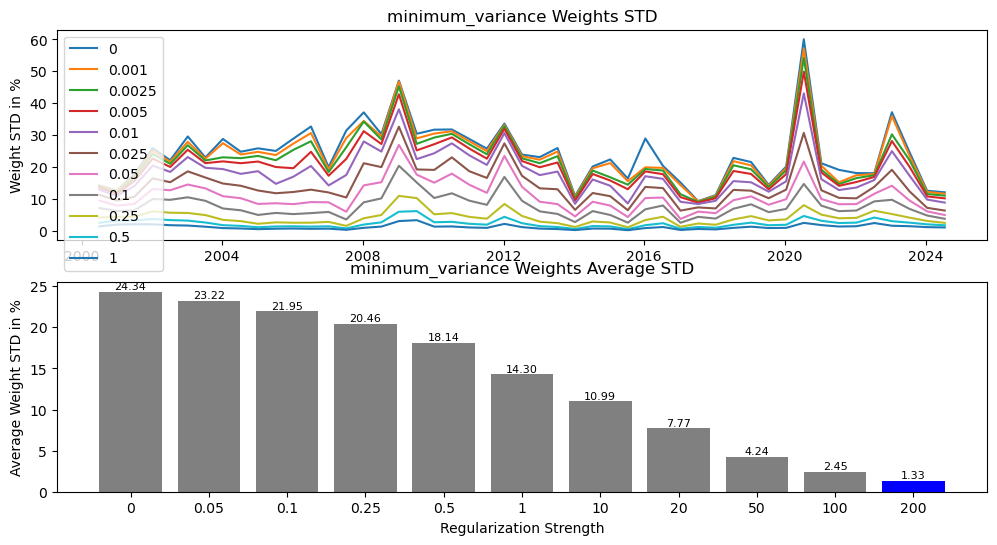

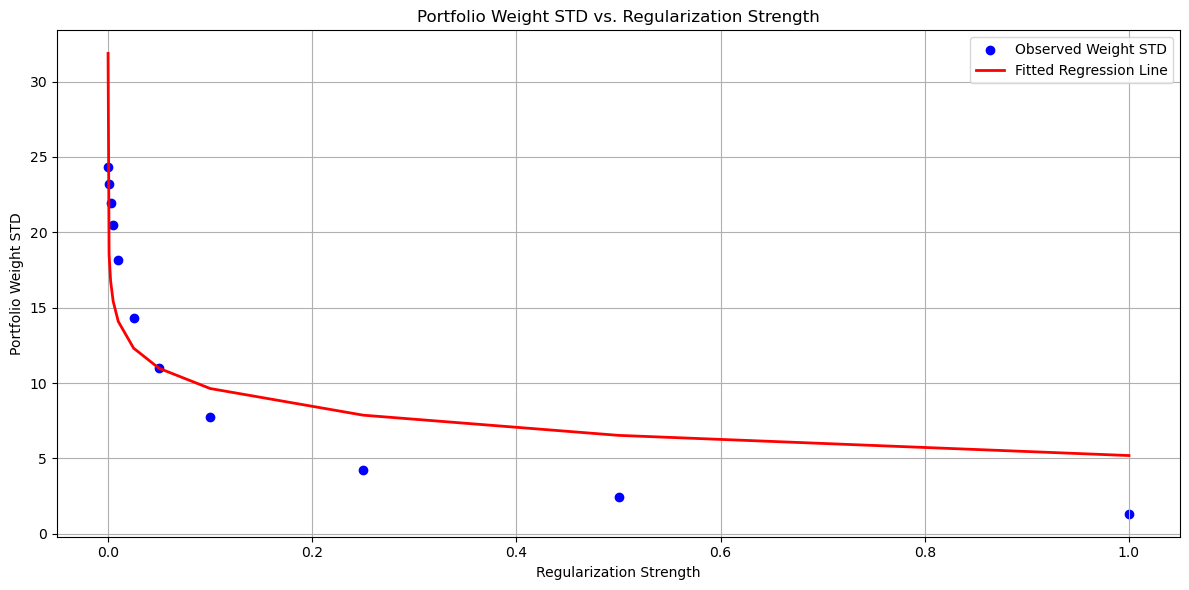

****************************************************************************************************
-----------------WEIGHT STD maximum_sharpe_ratio-----------------
[38.79607365 -3.87999986]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.552
Method:                 Least Squares   F-statistic:                     13.34
Date:                 Fr, 02 Mai 2025   Prob (F-statistic):            0.00529
Time:                        15:14:15   Log-Likelihood:                -46.276
No. Observations:                  11   AIC:                             96.55
Df Residuals:                       9   BIC:                             97.35
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 

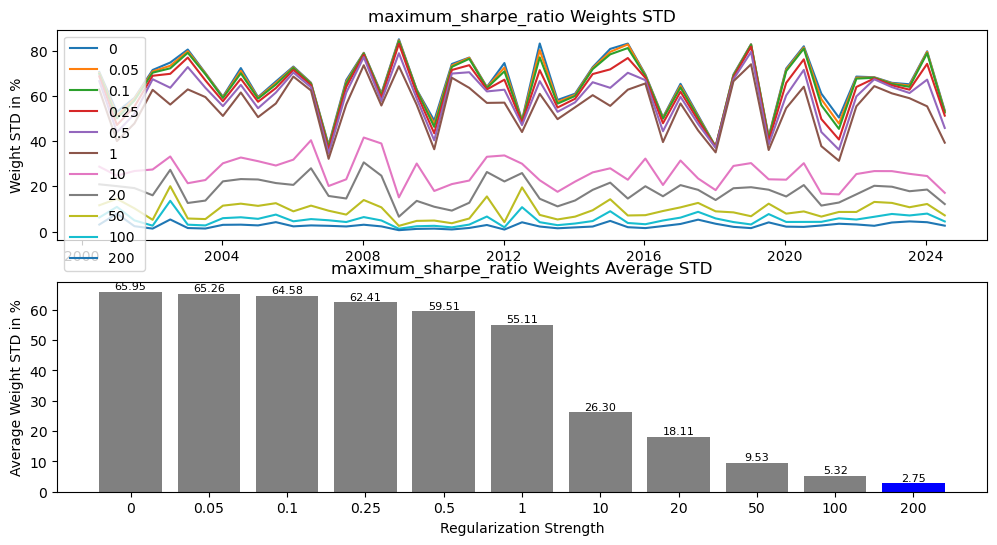

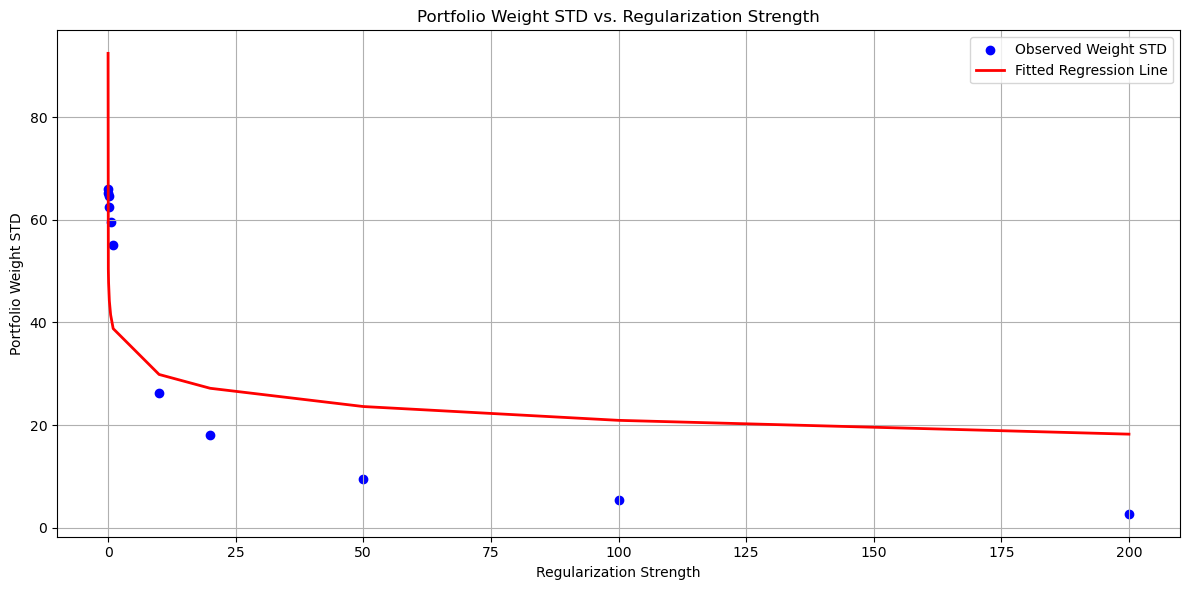

****************************************************************************************************


In [64]:
date_list: list[pd.Timestamp] = data.index.tolist()
min_date: pd.Timestamp = min(date_list)
previous_date: pd.Timestamp = min_date - pd.Timedelta(days=1)
date_list.insert(0, previous_date)

for i, portfolio_type in enumerate(['minimum_variance', 'maximum_sharpe_ratio']):
    if portfolio_type == 'minimum_variance':
        regularization_strengths: list[float] = [0, 0.001, 0.0025, 0.005, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 1]
    elif portfolio_type == 'maximum_sharpe_ratio':
        regularization_strengths: list[float] = [0, 0.05, 0.1, 0.25, 0.5, 1, 10, 20, 50, 100, 200]
        
    fig, axes = plt.subplots(2, 1, figsize=(12, 6))
    axes[0].set_title(f'{portfolio_type} Weights STD')
    for regularization_strength in regularization_strengths:
        axes[0].plot(data.index[rebalancing_dates], all_portfolios_performance_regularization_strengths_weights[f'{portfolio_type}_l2_{regularization_strength}'], label=f'{regularization_strength}')
    axes[0].legend(loc='upper left')
    # axes_0_xlabel = axes[0].set_xlabel('Date')
    # axes_0_xlabel.set_position((0.025, 0))
    axes[0].set_ylabel('Weight STD in %')
    
    # Determine the lowest mean weight STD

    portfolio_weights_std_average: list[float] = [all_portfolios_performance_regularization_strengths_weights[f'{portfolio_type}_l2_{regularization_strength}'].mean() for regularization_strength in regularization_strengths]
    min_index_weight_std = np.argmin(portfolio_weights_std_average)
    
    axes[1].set_title(f'{portfolio_type} Weights Average STD')
    axes[1].set_xlabel('Regularization Strength')
    axes[1].set_ylabel('Average Weight STD in %')
    # Plot bars (blue for max, gray for others)
    for j, (label, value) in enumerate(zip(labels, portfolio_weights_std_average)):
        color = 'blue' if j == min_index_weight_std else 'gray'
        axes[1].bar(label, value, color=color)
        axes[1].text(label, value, f'{value:.2f}', ha='center', va='bottom', fontsize=8)
        
    epsilon: float = 1e-6
    ols_regularization_strengths = np.log(np.array(regularization_strengths) + epsilon)
    ols_regularization_strengths = sm.add_constant(ols_regularization_strengths)
    # --> adding a log term does not increase the R²
    # ols_regularization_strengths = sm.add_constant(regularization_strengths)
    
    model_weights = sm.OLS(portfolio_weights_std_average, ols_regularization_strengths)
    result_weight_std = model_weights.fit()
    predicted_portfolio_weights_std_average: np.array = result_weight_std.predict(ols_regularization_strengths)
    
    print(f'-----------------WEIGHT STD {portfolio_type}-----------------')
    print(result_weight_std.params)
    print(result_weight_std.summary())
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot()
    plt.scatter(regularization_strengths, portfolio_weights_std_average, color='blue', label='Observed Weight STD')
    plt.plot(regularization_strengths, predicted_portfolio_weights_std_average, color='red', linewidth=2, label='Fitted Regression Line')
    plt.xlabel('Regularization Strength')
    plt.ylabel('Portfolio Weight STD')
    plt.title('Portfolio Weight STD vs. Regularization Strength')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print('*'*100)